In [1]:
WORK_DIR_PATH = ".."

In [2]:
TARGET = "LOG_AMOUNT"

# Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PROJECT\M2-PJT_STATS


In [5]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from BAYESIAN_DiD import model

# Data

In [6]:
df = pd.read_csv(f"./_data/sales.csv")

In [7]:
CAT_AREA = df['AREA'].astype('category')
df['AREA'] = CAT_AREA.cat.codes
AREA_LABEL = CAT_AREA.cat.categories

CAT_IND = df['INDUSTRY'].astype('category')
df['INDUSTRY'] = CAT_IND.cat.codes
IND_LABEL = CAT_IND.cat.categories

In [8]:
for i, cat in enumerate(AREA_LABEL):
    print(f"Label {i}: {cat}")

Label 0: 골목상권
Label 1: 관광특구
Label 2: 발달상권
Label 3: 전통시장


In [9]:
for i, cat in enumerate(IND_LABEL):
    print(f"Label {i}: {cat}")

Label 0: 가전제품업
Label 1: 건강서비스업
Label 2: 건강소매업
Label 3: 교육서비스업
Label 4: 부동산업
Label 5: 사치재소매업
Label 6: 생활서비스업
Label 7: 숙박업
Label 8: 실내여가업
Label 9: 외식업
Label 10: 자동차업
Label 11: 전자상거래업
Label 12: 필수재소매업


In [10]:
df.head()

TIME  YEAR  QUARTER  POST  AREA  INDUSTRY     COUNT        AMOUNT  \
0     0  2020        2     0     0         0  13016879   96975914913   
1     0  2020        2     0     0         1   6679518  182430757093   
2     0  2020        2     0     0         2  16410010  360977224528   
3     0  2020        2     0     0         3    451345  132232285601   
4     0  2020        2     0     0         4     29816    1183998884   

   LOG_COUNT  LOG_AMOUNT  
0  16.381758   25.297728  
1  15.714557   25.929637  
2  16.613402   26.612081  
3  13.019990   25.607826  
4  10.302834   20.892163

# Modeling

In [11]:
DiD = model.BayesianDiD(df, TARGET)

In [12]:
DiD.build()

In [13]:
trace = DiD.fit()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_tau, beta_tau, gamma_tau, alpha_raw, beta_raw, gamma_raw, omega, p_tau, q_tau, p_raw, q_raw, delta, u_tau, v_tau, u_raw, v_raw, eta, sigma]
>BinaryGibbsMetropolis: [D]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 1312 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
trace.to_netcdf(filename=f"./_trace/{TARGET}.nc")
# trace = az.from_netcdf(filename=f"./_trace/{TARGET}.nc")

'./_trace/LOG_AMOUNT.nc'

In [33]:
LAG = 10
trace_thinned = trace.sel(draw=slice(None, None, LAG))

# Posterior Convergence Diagnostics

Sampling: [y]


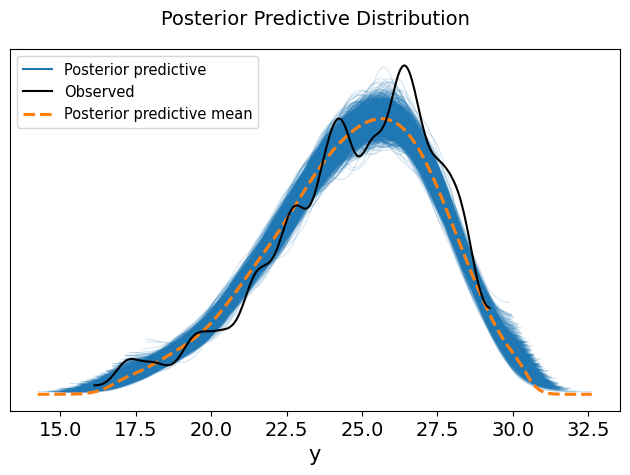

In [34]:
ppc = pm.sample_posterior_predictive(trace_thinned, model=DiD.model)

az.plot_ppc(ppc)
plt.suptitle(
    t=f"Posterior Predictive Distribution", 
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [68]:
VAR = ["omega", "alpha", "beta", "delta", "p", "q", "eta", "u", "v"]
SUMMARY = az.summary(trace_thinned, var_names=VAR)

CONDITION_MCSE = SUMMARY["mcse_mean"] > 0.1
CONDITION_ESS_BULK = SUMMARY["ess_bulk"] < 400
CONDITION_ESS_TAIL = SUMMARY["ess_tail"] < 100
CONDITION_R = SUMMARY["r_hat"] > 1.05

SUMMARY[CONDITION_MCSE | CONDITION_ESS_BULK | CONDITION_ESS_TAIL | CONDITION_R]

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
q[5]   1.246  0.518   0.277    2.129      0.049    0.032     126.0     174.0   
q[7]  -0.487  0.512  -1.485    0.445      0.039    0.047     260.0      93.0   
q[11] -1.738  0.408  -2.467   -0.970      0.021    0.008     387.0    1217.0   
u[0]  -3.698  1.435  -6.416   -1.014      0.079    0.024     326.0     652.0   
u[1]   0.196  1.622  -3.133    2.873      0.167    0.116     106.0      84.0   
v[2]  -1.985  2.403  -6.114    2.785      0.106    0.077     545.0     706.0   
v[3]   6.764  2.125   2.312   10.676      0.110    0.092     422.0     201.0   
v[5]   0.671  1.995  -3.119    4.181      0.214    0.189     121.0     178.0   
v[6]  -1.360  2.398  -5.936    2.977      0.131    0.067     346.0     807.0   
v[7]  -2.830  1.900  -6.015    1.365      0.189    0.107     102.0     109.0   
v[9]  -0.117  1.907  -3.802    3.121      0.138    0.074     208.0     726.0   
v[11]  0.788  1.779  -2.317    4.277      0.187    0.080     101.0     365.0   
v[12] -2.697  1.572  -5.746    0.185      0.098    0.030     255.0     673.0   

       r_hat  
q[5]    1.03  
q[7]    1.01  
q[11]   1.01  
u[0]    1.01  
u[1]    1.04  
v[2]    1.02  
v[3]    1.00  
v[5]    1.04  
v[6]    1.01  
v[7]    1.03  
v[9]    1.02  
v[11]   1.04  
v[12]   1.01

# Intercept

In [35]:
VAR = ["omega", "delta", "eta"]
VAR_RENAME = ["FIXED", "ATT", "TREATED"]
RENAME_DICT = {
    f"{VAR[i]}": f"{VAR_RENAME[i]}"
    for i in range(len(VAR))
}

### Summary

In [36]:
SUMMARY = az.summary(trace_thinned, var_names=VAR)
SUMMARY = SUMMARY.rename(index=RENAME_DICT)
SUMMARY

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
FIXED    2.069  1.003   0.279    3.998      0.023    0.016    1940.0   
ATT      0.479  0.607  -0.680    1.565      0.014    0.011    1750.0   
TREATED -0.227  0.854  -1.741    1.380      0.021    0.014    1629.0   

         ess_tail  r_hat  
FIXED      2014.0    1.0  
ATT        1655.0    1.0  
TREATED    1968.0    1.0

### Posterior Dist.

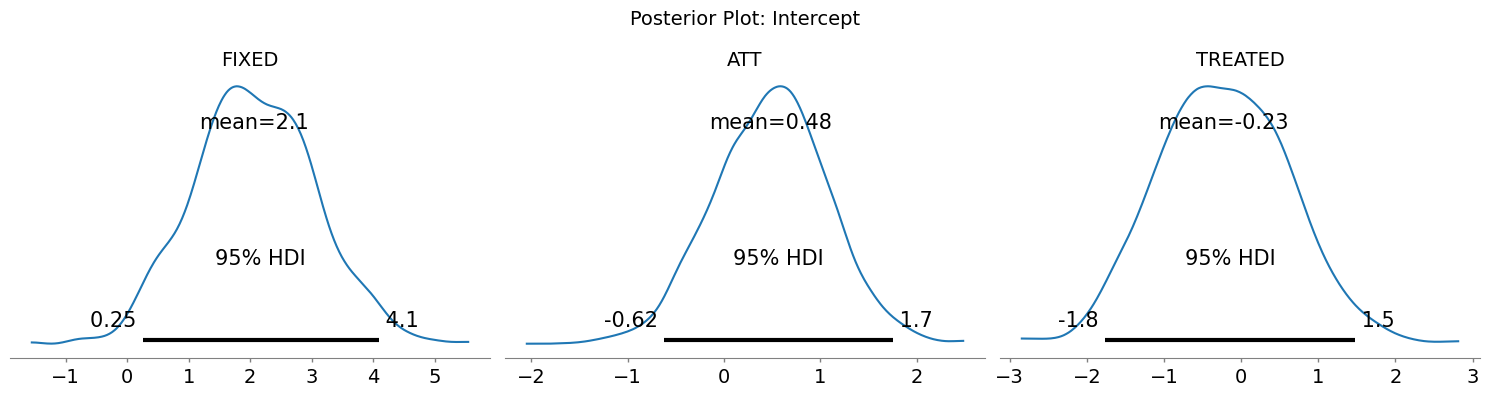

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(len(VAR)):
    az.plot_posterior(
        data=trace_thinned, 
        var_names=VAR[i], 
        hdi_prob=0.95,
        ax=ax[i],
    )
    ax[i].set_title(
        label=f"{VAR_RENAME[i]}", 
        fontsize=14,
    )

plt.suptitle(
    t=f"Posterior Plot: Intercept", 
    fontsize=14,
)
plt.tight_layout()
plt.show()

### MCMC Trace

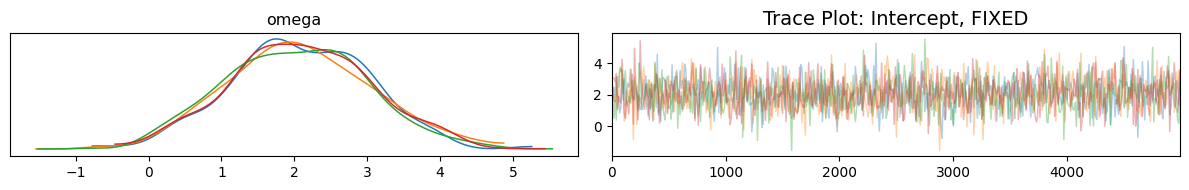

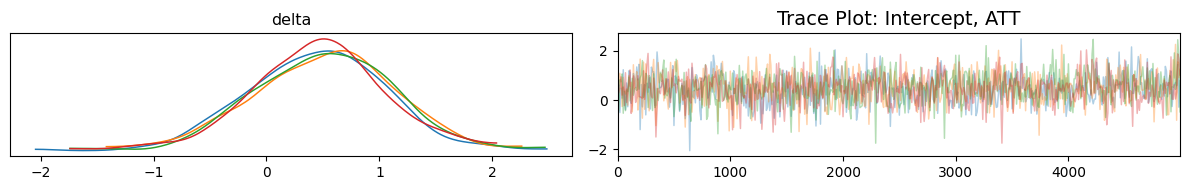

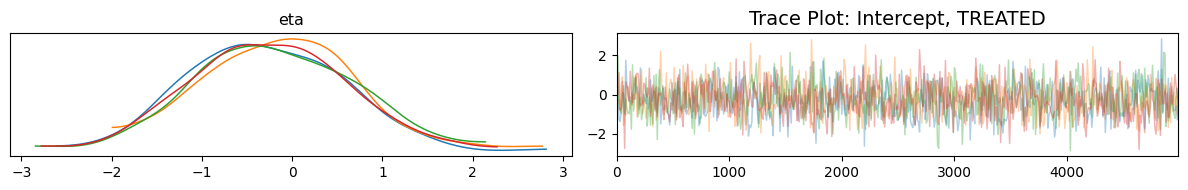

In [38]:
for i in range(len(VAR)):
    az.plot_trace(
        data=trace_thinned, 
        var_names=VAR[i], 
        compact=False,
    )
    plt.title(
        label=f"Trace Plot: Intercept, {VAR_RENAME[i]}", 
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()

### AutoCorrelation

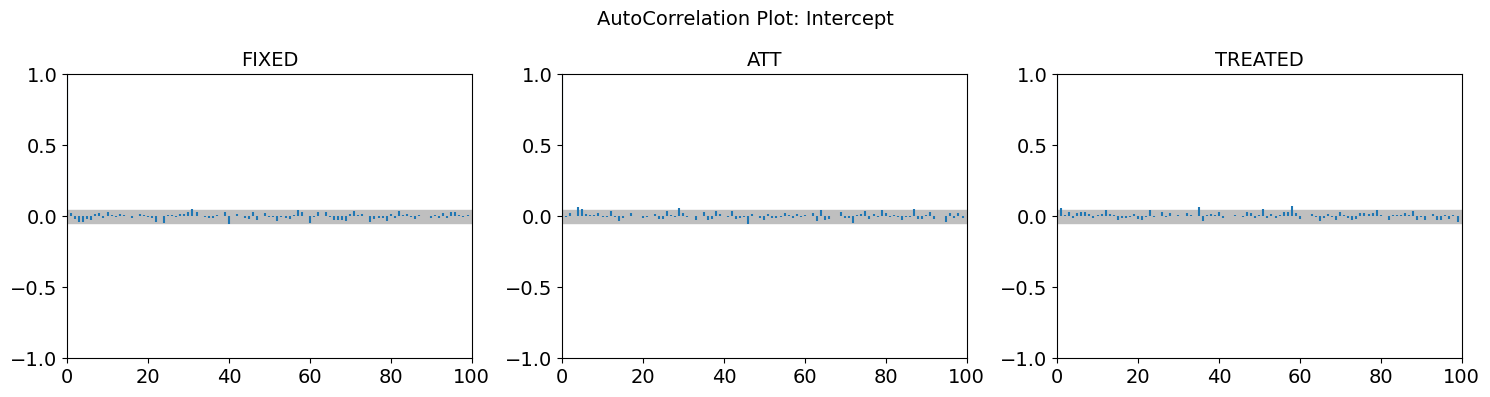

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(len(VAR)):
    az.plot_autocorr(
        data=trace_thinned, 
        var_names=VAR[i],
        combined=True,
        ax=ax[i],
    )
    ax[i].set_title(
        label=f"{VAR_RENAME[i]}", 
        fontsize=14,
    )

plt.suptitle(
    t=f"AutoCorrelation Plot: Intercept", 
    fontsize=14,
)
plt.tight_layout()
plt.show()

# Area

In [40]:
VAR = ["alpha", "p", "u"]
VAR_RENAME = ["FIXED", "ATT", "TREATED"]
RENAME_DICT = {
    f"{VAR[i]}[{j}]": f"{VAR_RENAME[i]} ({AREA_LABEL[j]})"
    for i in range(len(VAR))
    for j in range(len(AREA_LABEL))
}

### Summary

In [41]:
SUMMARY = az.summary(trace_thinned, var_names=VAR)
SUMMARY = SUMMARY.rename(index=RENAME_DICT)
SUMMARY

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
FIXED (골목상권)    22.312  1.198  19.992   24.369      0.027    0.020    2003.0   
FIXED (관광특구)    20.356  1.200  18.062   22.451      0.027    0.020    2001.0   
FIXED (발달상권)    23.633  1.197  21.397   25.795      0.027    0.020    2010.0   
FIXED (전통시장)    21.036  1.199  18.770   23.177      0.027    0.020    2003.0   
ATT (골목상권)       1.867  0.617   0.848    3.116      0.016    0.013    1532.0   
ATT (관광특구)      -1.013  0.608  -2.163    0.100      0.029    0.012     432.0   
ATT (발달상권)       0.649  0.642  -0.581    1.819      0.014    0.016    1962.0   
ATT (전통시장)      -0.692  0.585  -1.765    0.420      0.013    0.011    1893.0   
TREATED (골목상권)  -3.698  1.435  -6.416   -1.014      0.079    0.024     326.0   
TREATED (관광특구)   0.196  1.622  -3.133    2.873      0.167    0.116     106.0   
TREATED (발달상권)  -4.655  1.711  -7.713   -1.465      0.090    0.085     424.0   
TREATED (전통시장)   6.638  1.772   3.512   10.033      0.063    0.034     768.0   

                ess_tail  r_hat  
FIXED (골목상권)      1868.0   1.00  
FIXED (관광특구)      1834.0   1.00  
FIXED (발달상권)      1906.0   1.00  
FIXED (전통시장)      1868.0   1.00  
ATT (골목상권)        1767.0   1.00  
ATT (관광특구)         829.0   1.01  
ATT (발달상권)        1710.0   1.00  
ATT (전통시장)        1840.0   1.00  
TREATED (골목상권)     652.0   1.01  
TREATED (관광특구)      84.0   1.04  
TREATED (발달상권)     355.0   1.01  
TREATED (전통시장)    1406.0   1.00

### Posterior Dist.

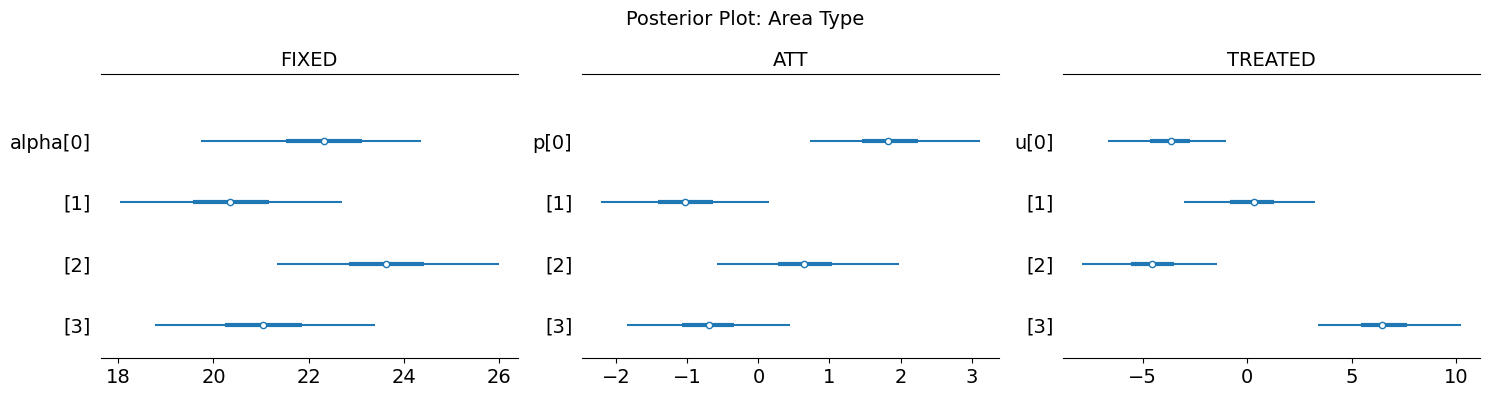

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(len(VAR)):
    az.plot_forest(
        data=trace_thinned, 
        var_names=VAR[i], 
        hdi_prob=0.95,
        combined=True,
        kind="forestplot",
        ax=ax[i],
    )
    ax[i].set_title(
        label=f"{VAR_RENAME[i]}", 
        fontsize=14,
    )

plt.suptitle(
    t=f"Posterior Plot: Area Type", 
    fontsize=14,
)
plt.tight_layout()
plt.show()

### MCMC Trace

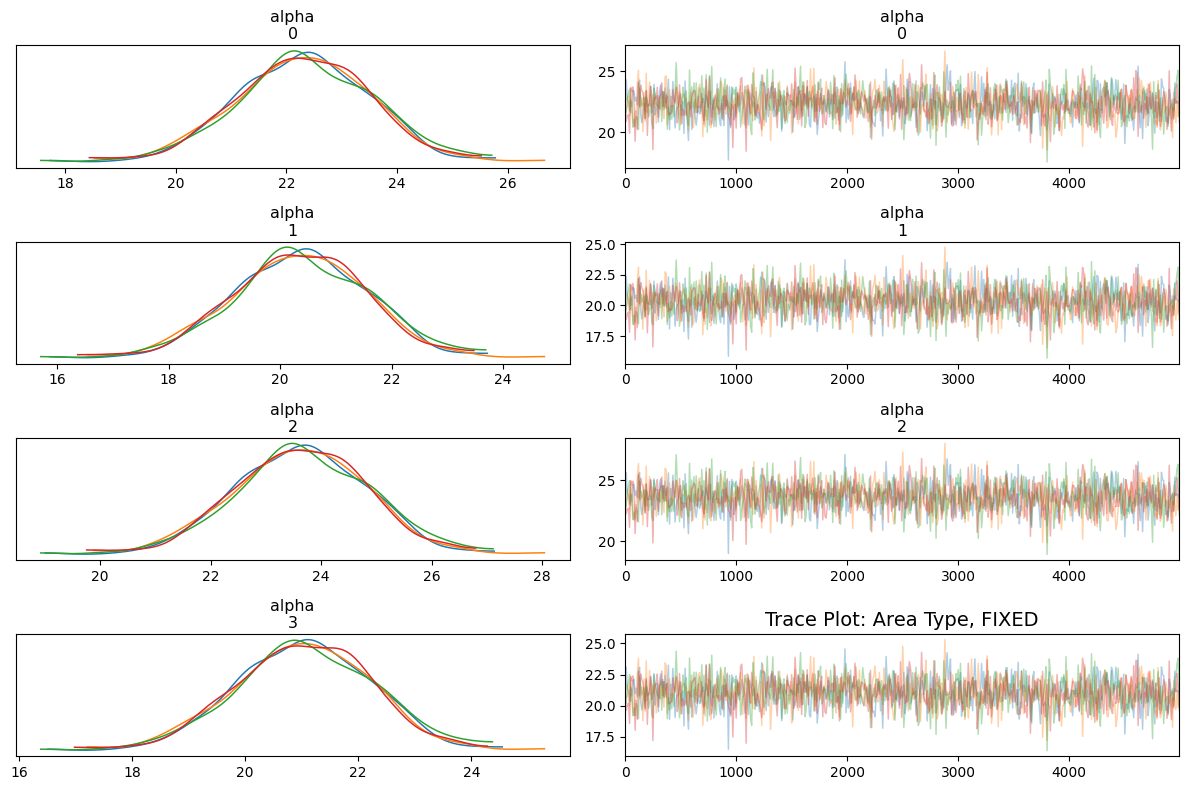

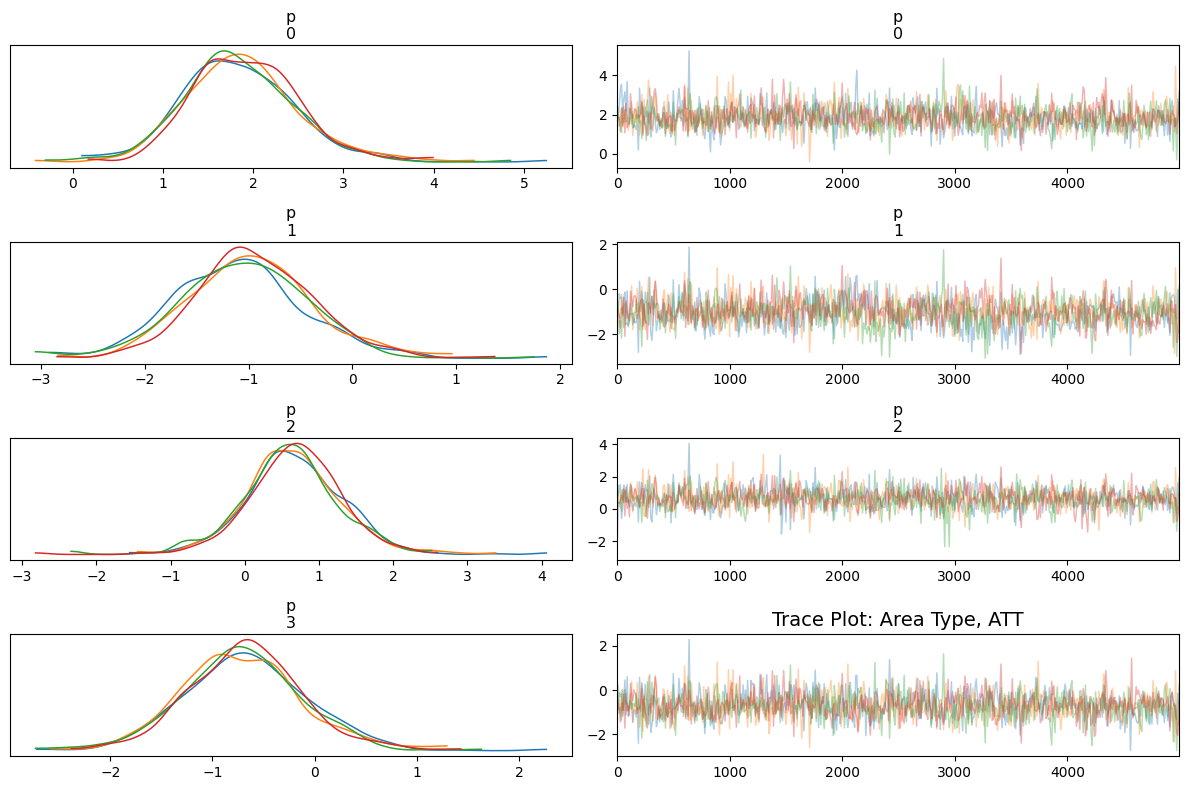

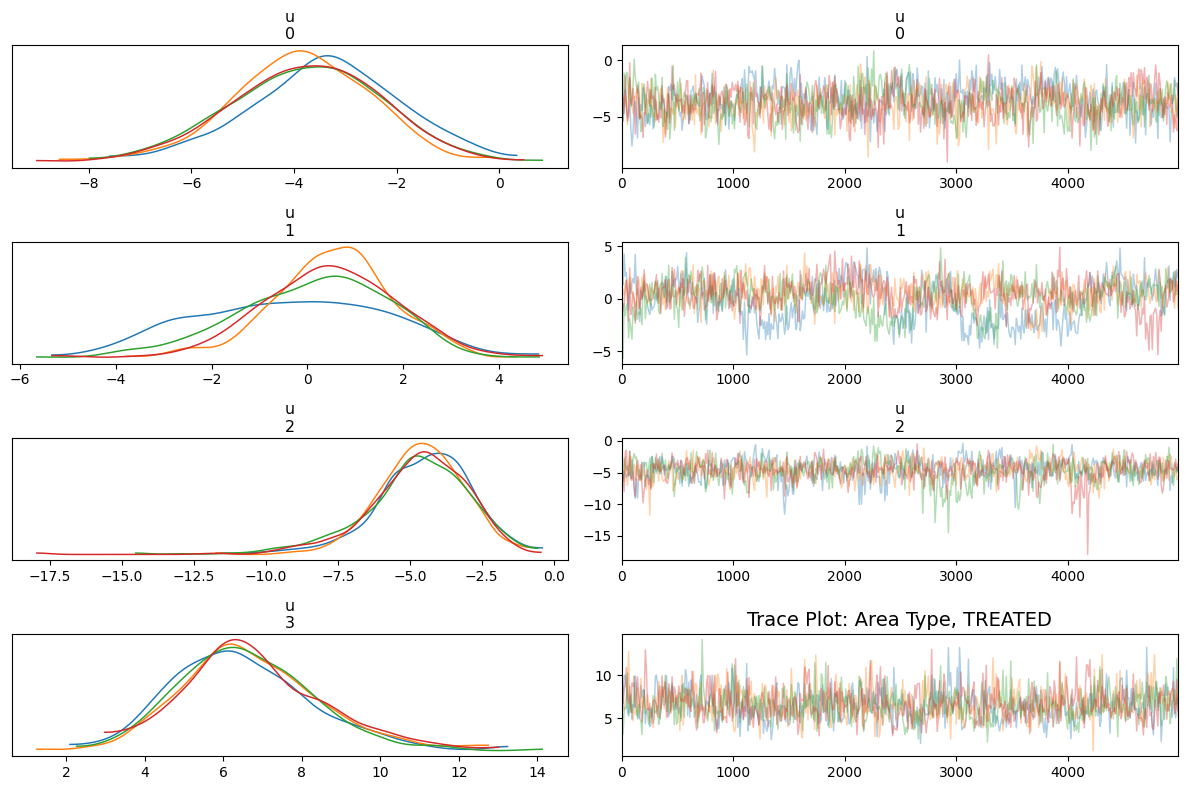

In [43]:
for i in range(len(VAR)):
    az.plot_trace(
        data=trace_thinned, 
        var_names=VAR[i], 
        compact=False,
    )
    plt.title(
        label=f"Trace Plot: Area Type, {VAR_RENAME[i]}", 
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()

### AutoCorrelation

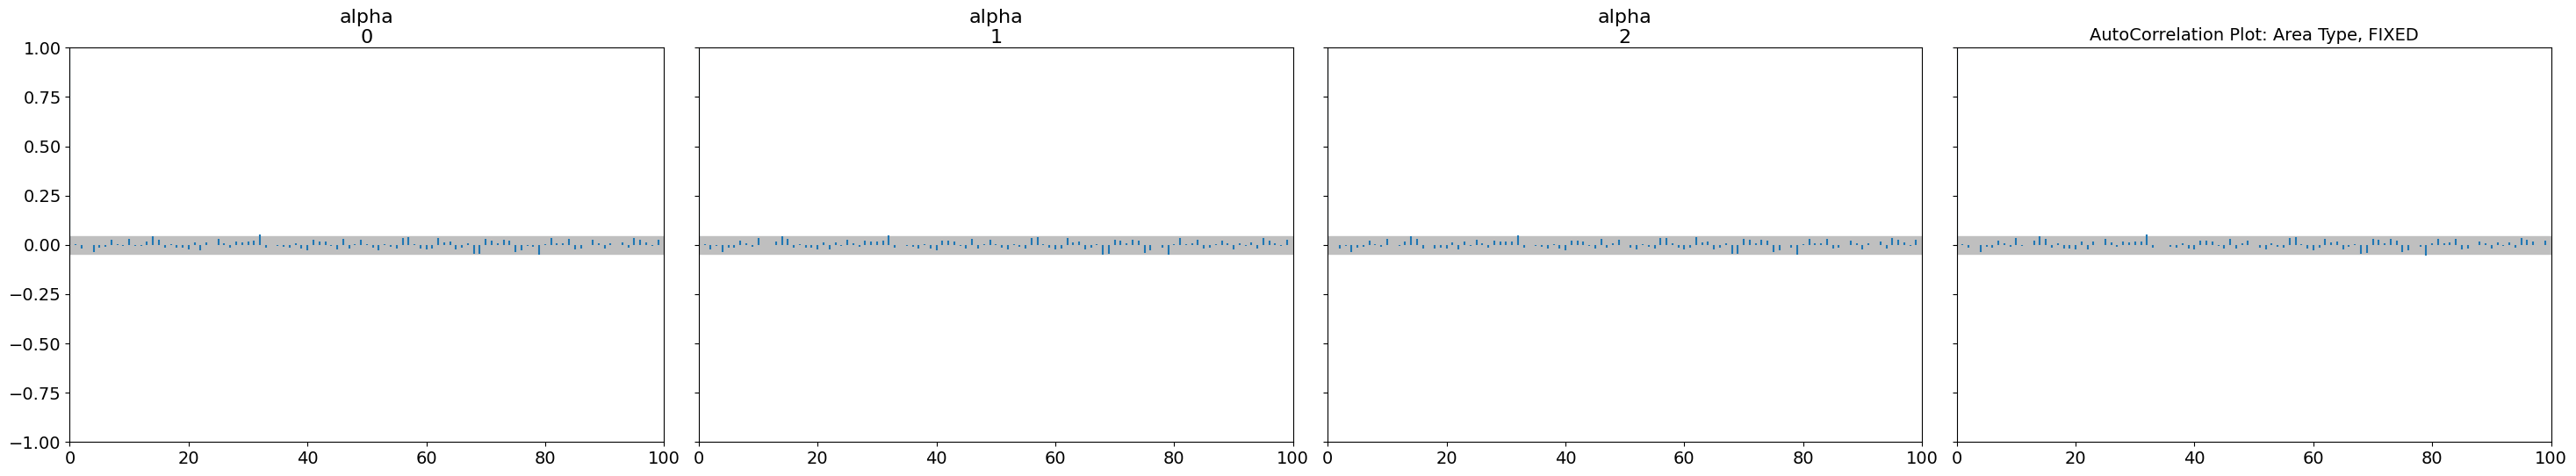

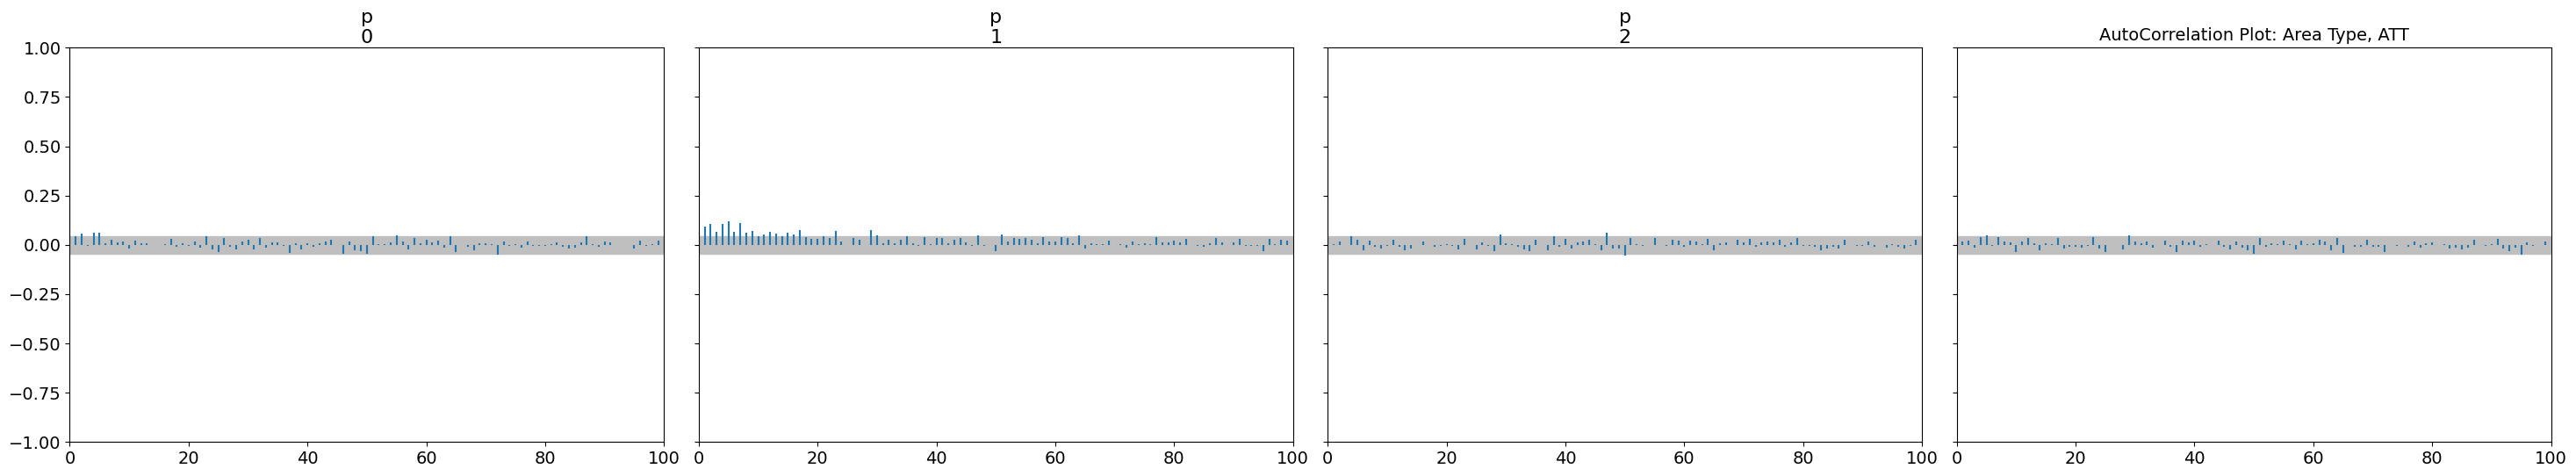

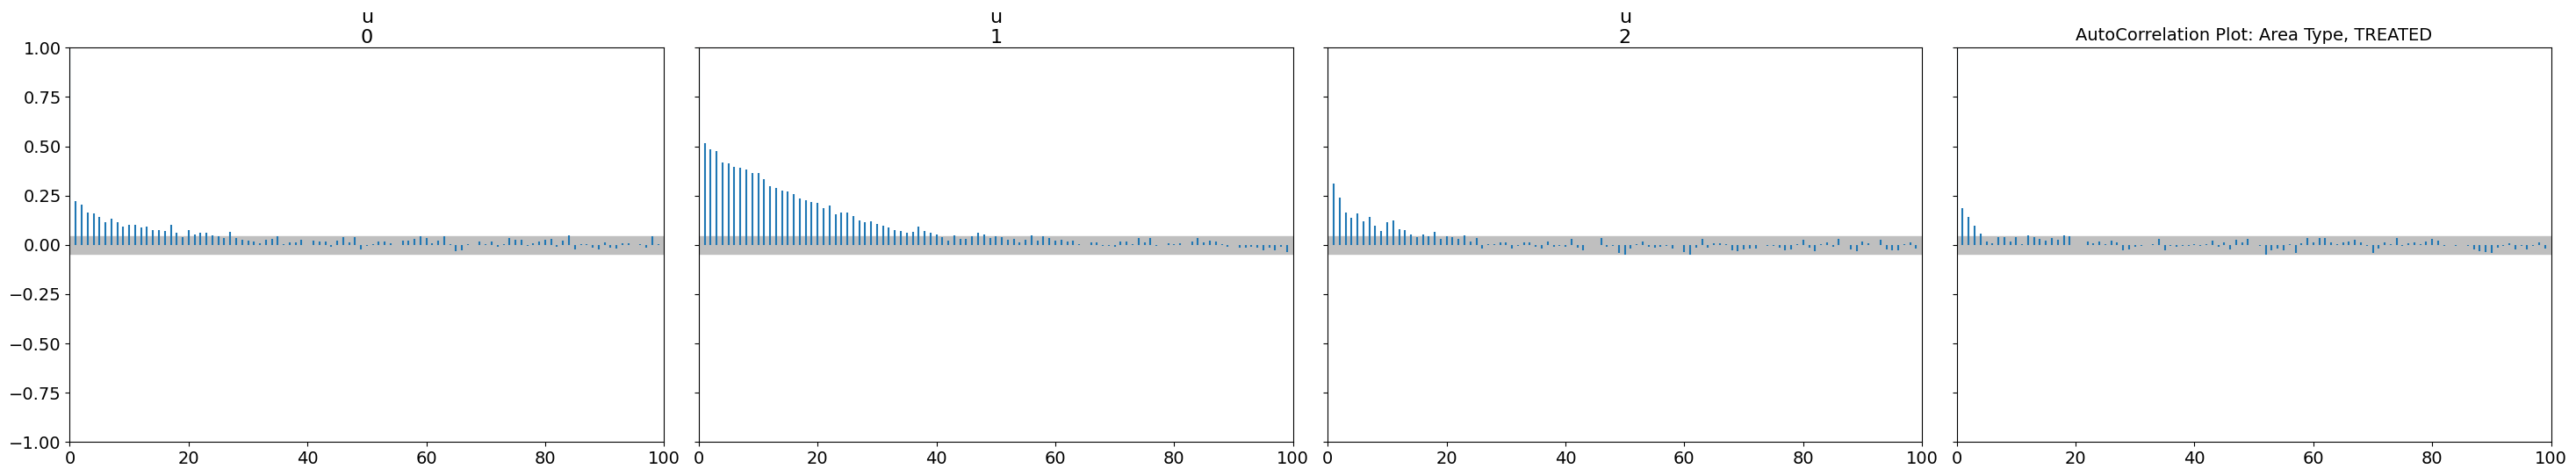

In [44]:
for i in range(len(VAR)):
    az.plot_autocorr(
        data=trace_thinned, 
        var_names=VAR[i],
        combined=True,
    )
    plt.title(
        label=f"AutoCorrelation Plot: Area Type, {VAR_RENAME[i]}", 
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()

# Industry

In [45]:
VAR = ["beta", "q", "v"]
VAR_RENAME = ["FIXED", "ATT", "TREATED"]
RENAME_DICT = {
    f"{VAR[i]}[{j}]": f"{VAR_RENAME[i]} ({IND_LABEL[j]})"
    for i in range(len(VAR))
    for j in range(len(IND_LABEL))
}

### Summary

In [46]:
SUMMARY = az.summary(trace_thinned, var_names=VAR)
SUMMARY = SUMMARY.rename(index=RENAME_DICT)
SUMMARY

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
FIXED (가전제품업)     1.126  0.643  -0.017    2.367      0.014    0.012    2027.0   
FIXED (건강서비스업)    2.170  0.643   1.020    3.401      0.014    0.012    2016.0   
FIXED (건강소매업)     2.051  0.640   0.947    3.330      0.014    0.012    2041.0   
FIXED (교육서비스업)    0.558  0.652  -0.627    1.774      0.016    0.013    1624.0   
FIXED (부동산업)     -3.697  0.639  -4.887   -2.499      0.014    0.012    2005.0   
FIXED (사치재소매업)    3.012  0.649   1.862    4.232      0.015    0.012    1852.0   
FIXED (생활서비스업)    0.915  0.645  -0.260    2.097      0.014    0.013    1992.0   
FIXED (숙박업)      -0.975  0.642  -2.075    0.318      0.015    0.012    1945.0   
FIXED (실내여가업)     0.454  0.642  -0.702    1.649      0.014    0.013    2030.0   
FIXED (외식업)       3.638  0.641   2.515    4.898      0.014    0.012    1985.0   
FIXED (자동차업)     -0.862  0.644  -1.980    0.408      0.014    0.012    2059.0   
FIXED (전자상거래업)   -2.011  0.638  -3.221   -0.847      0.014    0.012    1995.0   
FIXED (필수재소매업)    3.332  0.643   2.188    4.590      0.014    0.012    2000.0   
ATT (가전제품업)      -0.513  0.405  -1.320    0.196      0.010    0.007    1776.0   
ATT (건강서비스업)      0.900  0.416   0.126    1.667      0.010    0.008    1723.0   
ATT (건강소매업)       0.471  0.479  -0.368    1.281      0.012    0.022    1583.0   
ATT (교육서비스업)     -0.469  0.388  -1.192    0.250      0.015    0.006     703.0   
ATT (부동산업)       -1.734  0.449  -2.618   -0.925      0.010    0.008    1906.0   
ATT (사치재소매업)      1.246  0.518   0.277    2.129      0.049    0.032     126.0   
ATT (생활서비스업)      0.603  0.459  -0.249    1.418      0.015    0.016    1093.0   
ATT (숙박업)        -0.487  0.512  -1.485    0.445      0.039    0.047     260.0   
ATT (실내여가업)       0.794  0.418  -0.007    1.534      0.010    0.011    1919.0   
ATT (외식업)         0.919  0.416   0.178    1.690      0.013    0.011     973.0   
ATT (자동차업)       -0.984  0.395  -1.680   -0.235      0.016    0.006     590.0   
ATT (전자상거래업)     -1.738  0.408  -2.467   -0.970      0.021    0.008     387.0   
ATT (필수재소매업)      1.783  0.409   0.977    2.502      0.009    0.007    1977.0   
TREATED (가전제품업)  -0.642  2.032  -4.454    3.119      0.076    0.038     708.0   
TREATED (건강서비스업) -1.884  1.939  -5.636    1.589      0.059    0.041    1065.0   
TREATED (건강소매업)  -1.985  2.403  -6.114    2.785      0.106    0.077     545.0   
TREATED (교육서비스업)  6.764  2.125   2.312   10.676      0.110    0.092     422.0   
TREATED (부동산업)   -3.195  1.884  -6.732    0.150      0.083    0.030     496.0   
TREATED (사치재소매업)  0.671  1.995  -3.119    4.181      0.214    0.189     121.0   
TREATED (생활서비스업) -1.360  2.398  -5.936    2.977      0.131    0.067     346.0   
TREATED (숙박업)    -2.830  1.900  -6.015    1.365      0.189    0.107     102.0   
TREATED (실내여가업)  -1.836  2.033  -5.641    2.025      0.063    0.043    1062.0   
TREATED (외식업)    -0.117  1.907  -3.802    3.121      0.138    0.074     208.0   
TREATED (자동차업)    6.707  1.818   3.406   10.153      0.048    0.033    1378.0   
TREATED (전자상거래업)  0.788  1.779  -2.317    4.277      0.187    0.080     101.0   
TREATED (필수재소매업) -2.697  1.572  -5.746    0.185      0.098    0.030     255.0   

                  ess_tail  r_hat  
FIXED (가전제품업)       1972.0   1.00  
FIXED (건강서비스업)      2103.0   1.00  
FIXED (건강소매업)       1993.0   1.00  
FIXED (교육서비스업)      2010.0   1.00  
FIXED (부동산업)        2103.0   1.00  
FIXED (사치재소매업)      2057.0   1.00  
FIXED (생활서비스업)      1846.0   1.00  
FIXED (숙박업)         2058.0   1.00  
FIXED (실내여가업)       1933.0   1.00  
FIXED (외식업)         1933.0   1.00  
FIXED (자동차업)        2013.0   1.00  
FIXED (전자상거래업)      2055.0   1.00  
FIXED (필수재소매업)      2015.0   1.00  
ATT (가전제품업)         1727.0   1.00  
ATT (건강서비스업)        1807.0   1.00  
ATT (건강소매업)         1185.0   1.00  
ATT (교육서비스업)        1786.0   1.01  
ATT (부동산업)          2059.0   1.00  
ATT (사치재소매업)         174.0   1.03  
ATT (생활서비스업)        1304.0   1.00  
ATT (숙박업)             

### Posterior Dist.

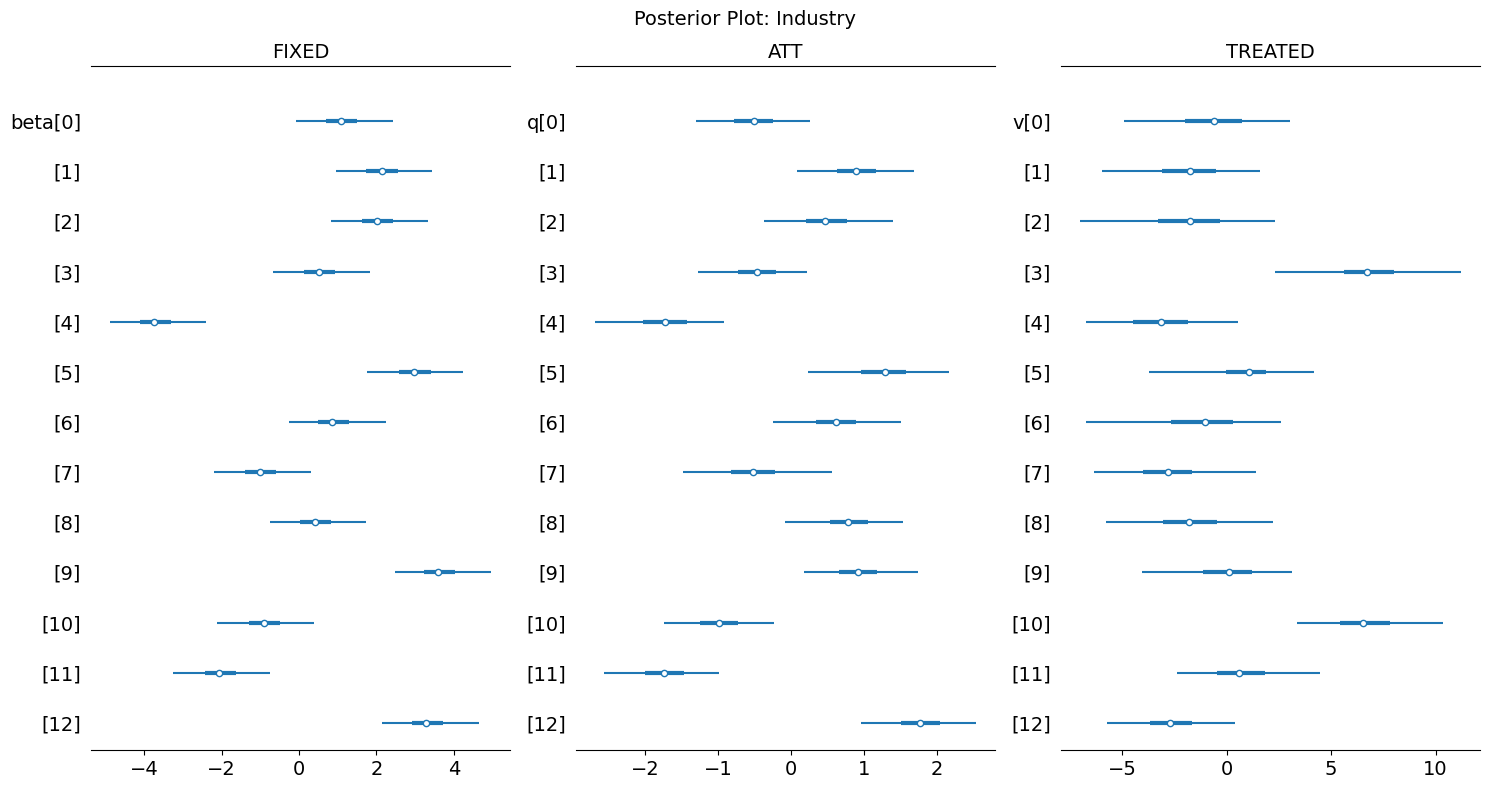

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

for i in range(len(VAR)):
    az.plot_forest(
        data=trace_thinned, 
        var_names=VAR[i], 
        hdi_prob=0.95,
        combined=True,
        kind="forestplot",
        ax=ax[i],
    )
    ax[i].set_title(
        label=f"{VAR_RENAME[i]}", 
        fontsize=14,
    )

plt.suptitle(
    t=f"Posterior Plot: Industry", 
    fontsize=14,
)
plt.tight_layout()
plt.show()

### MCMC Trace

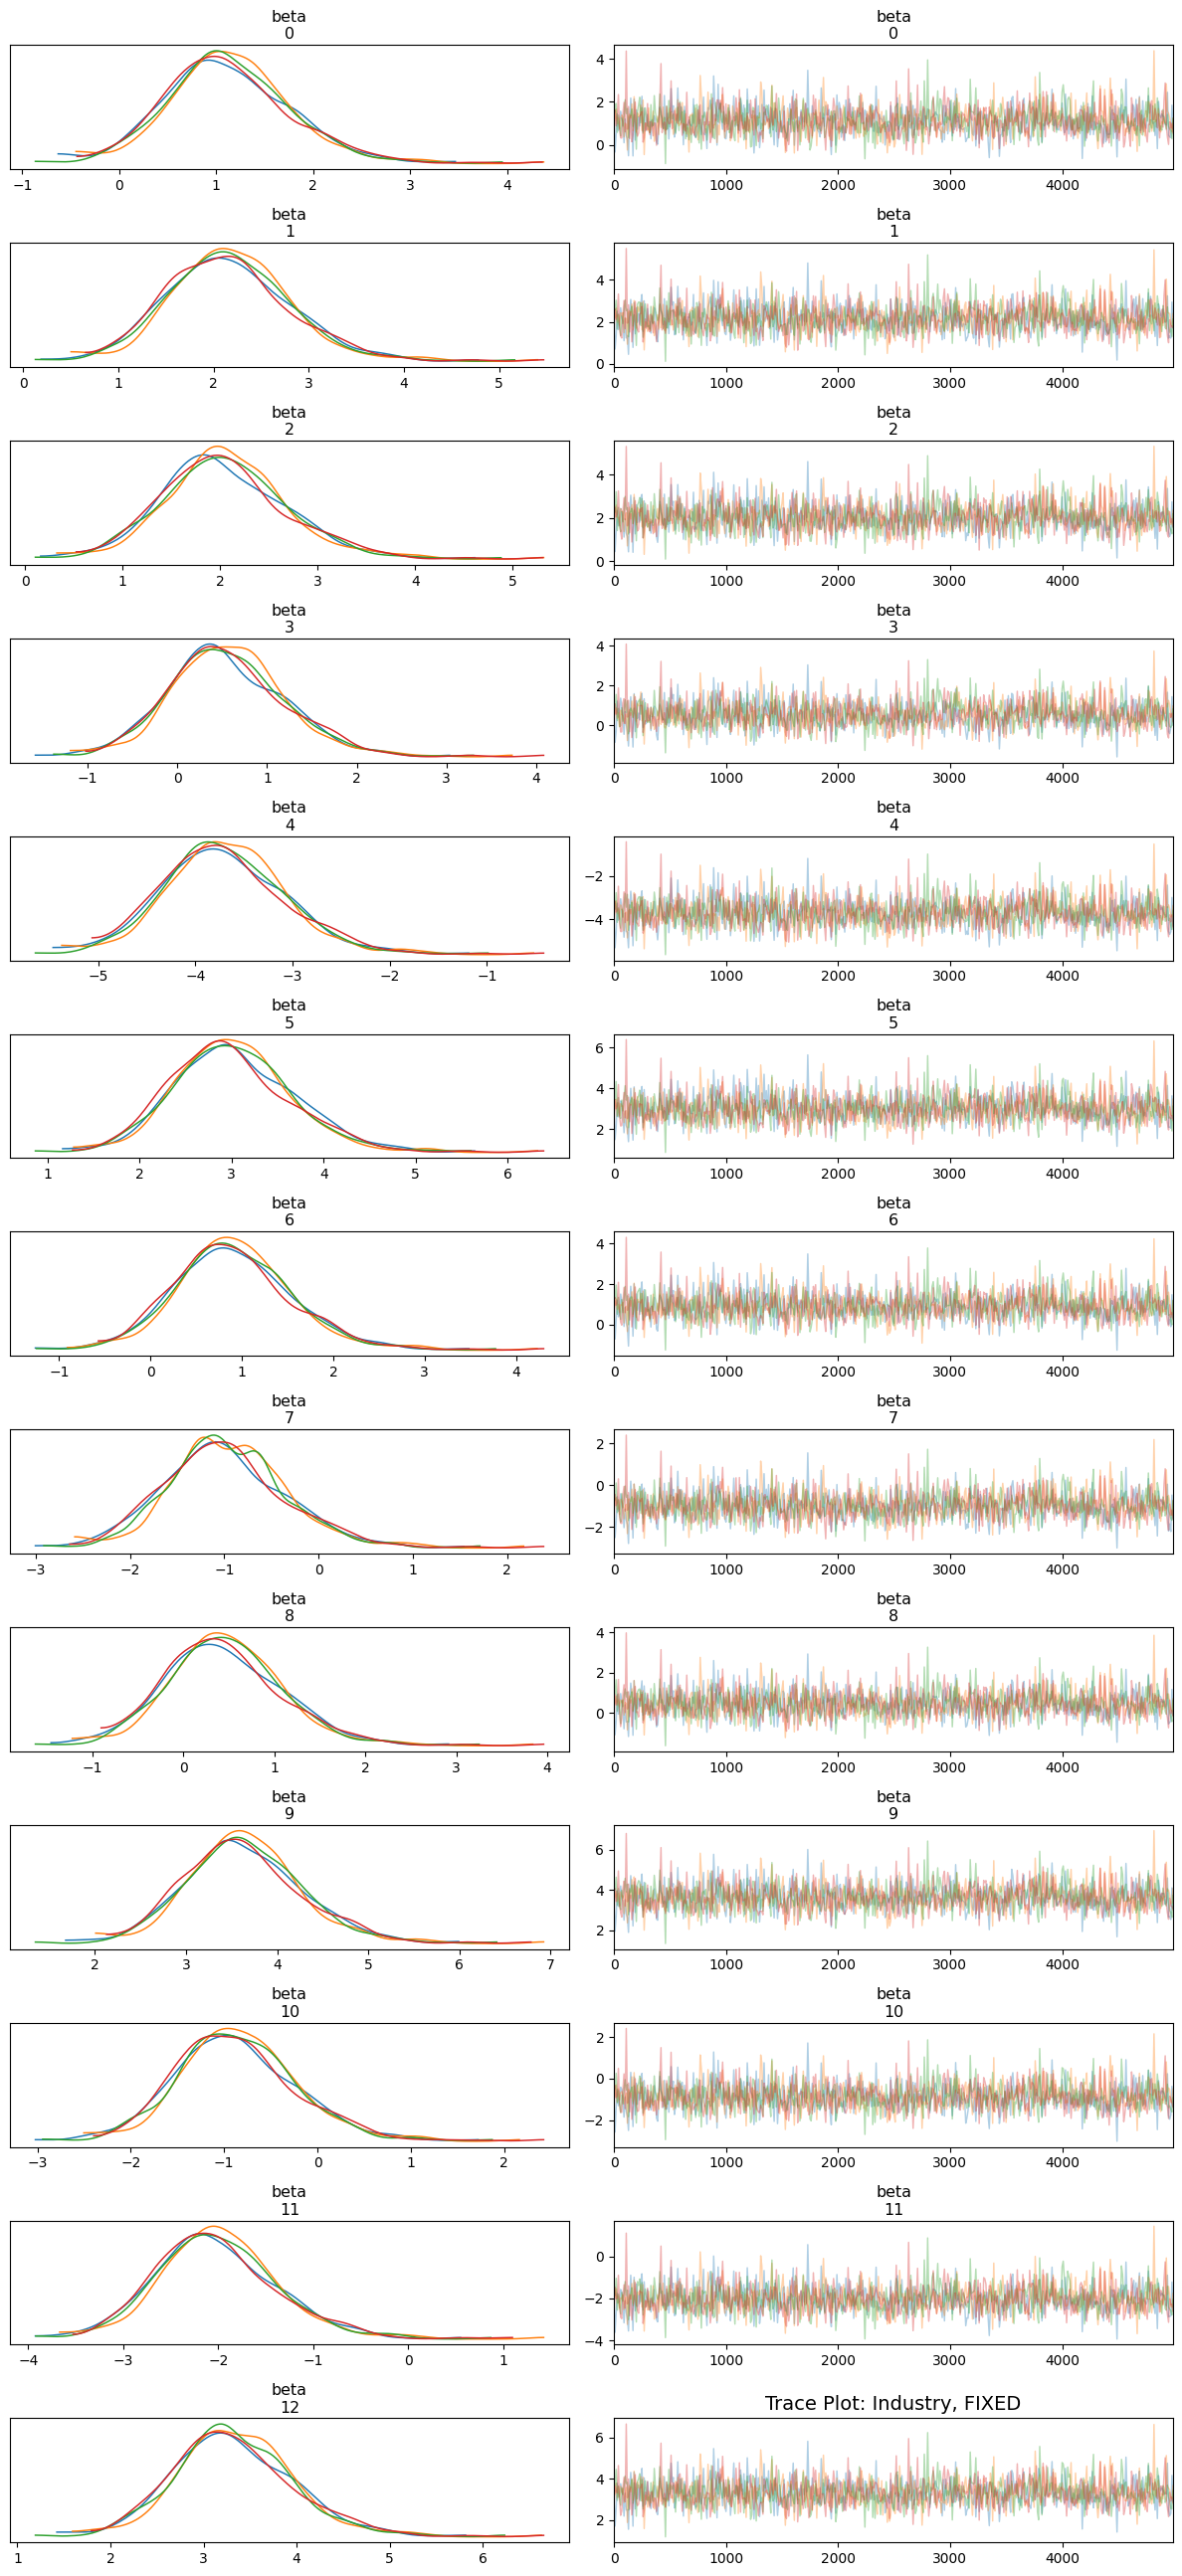

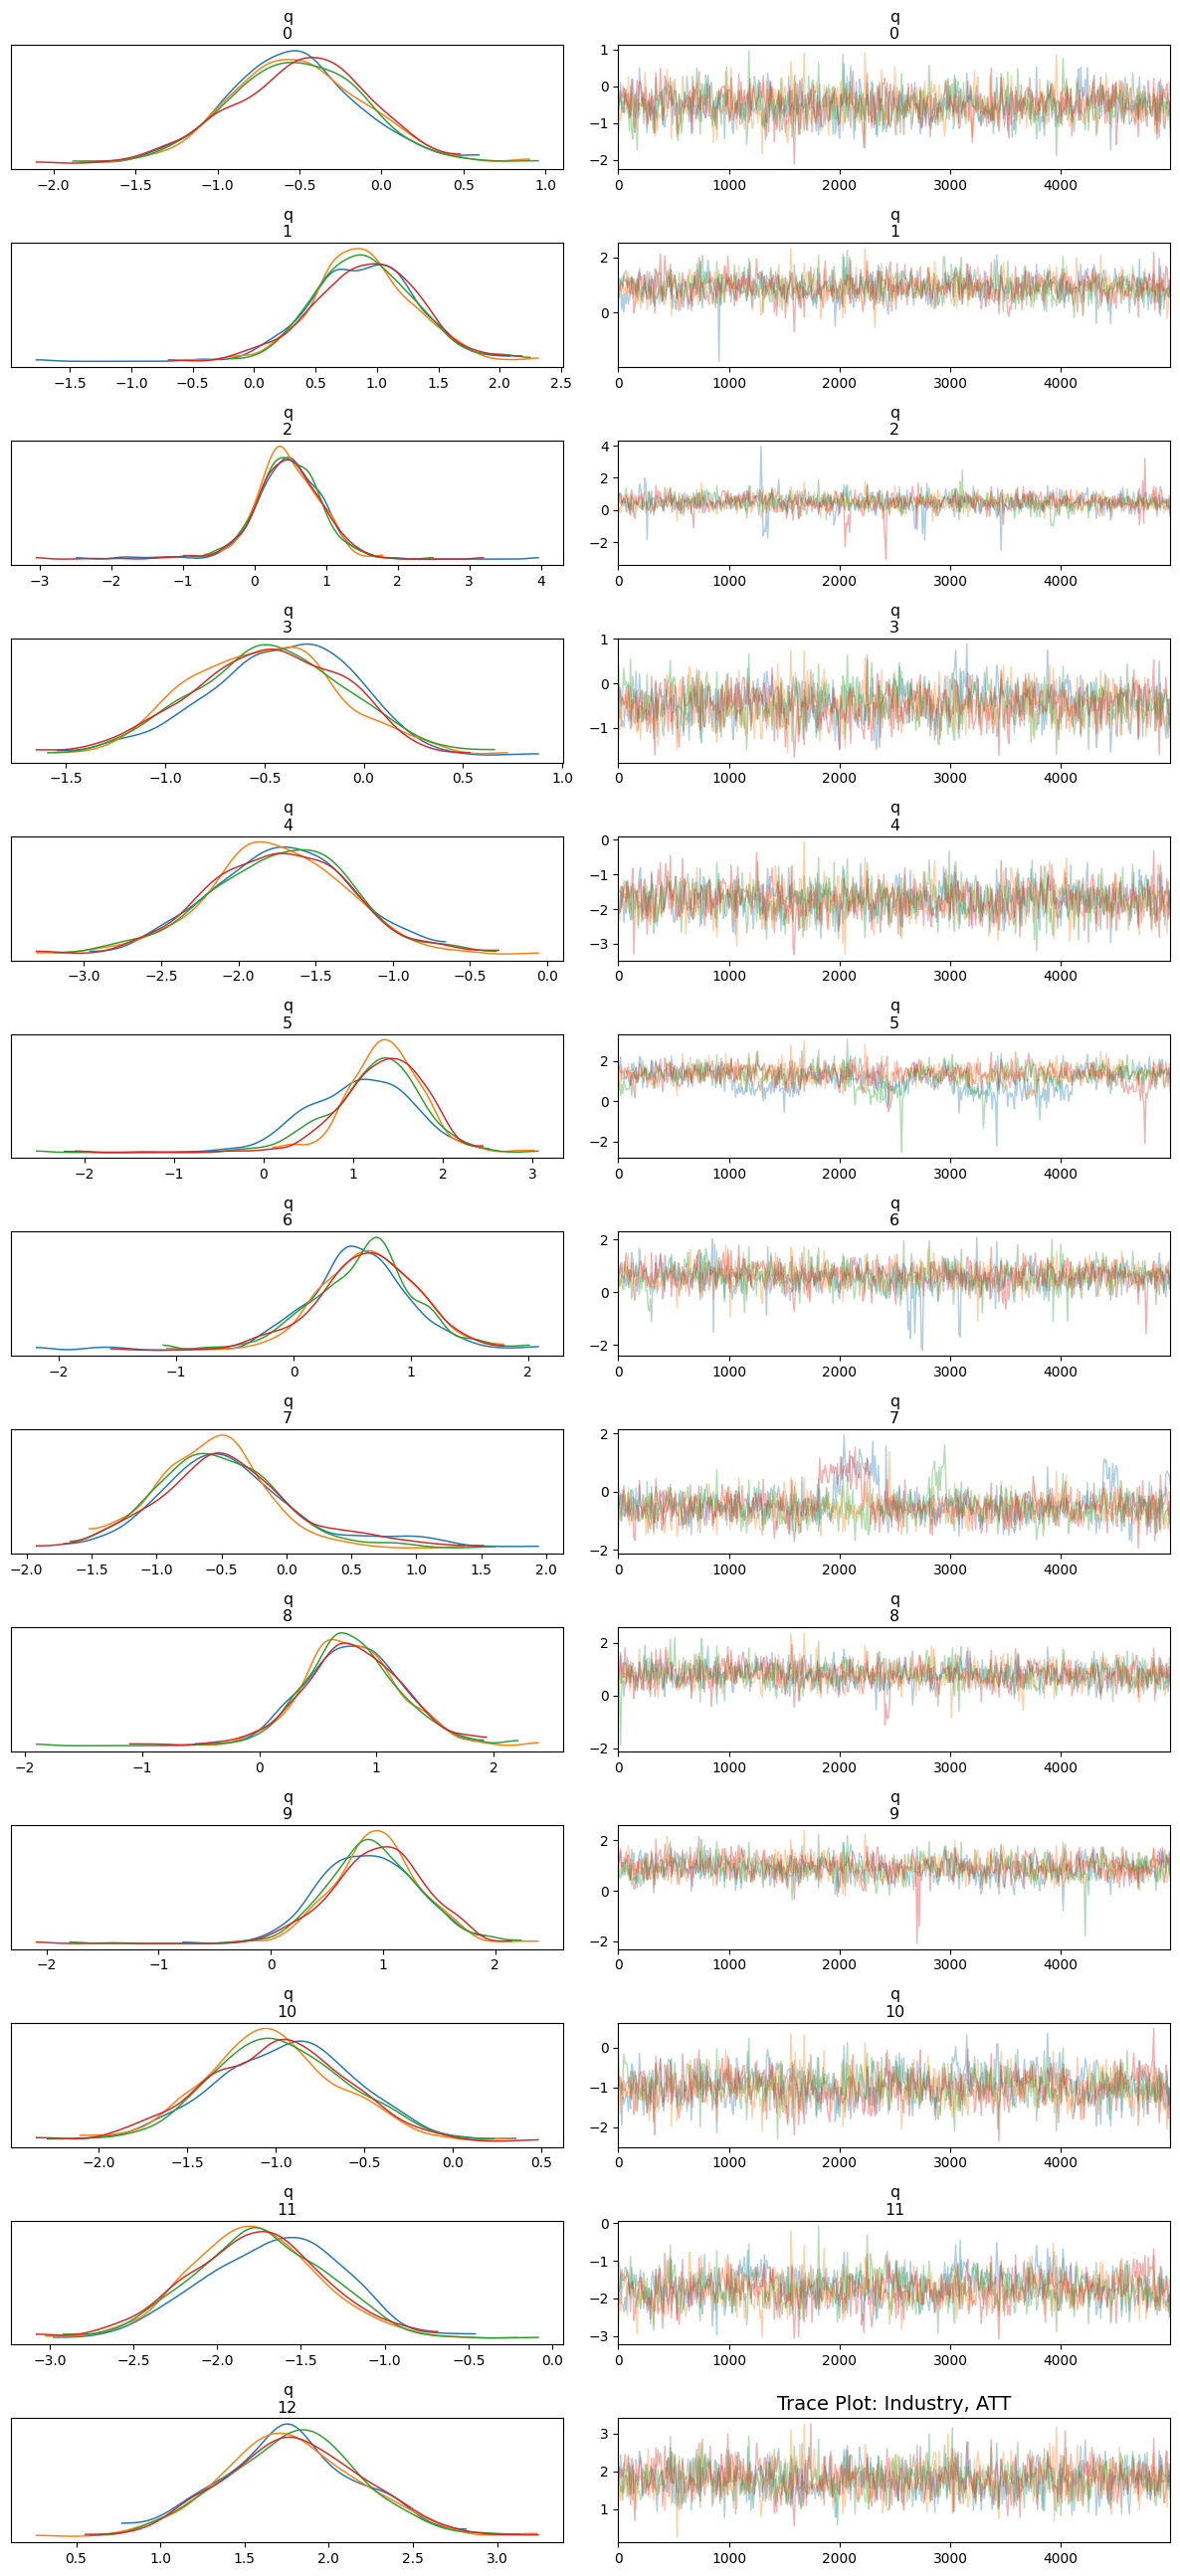

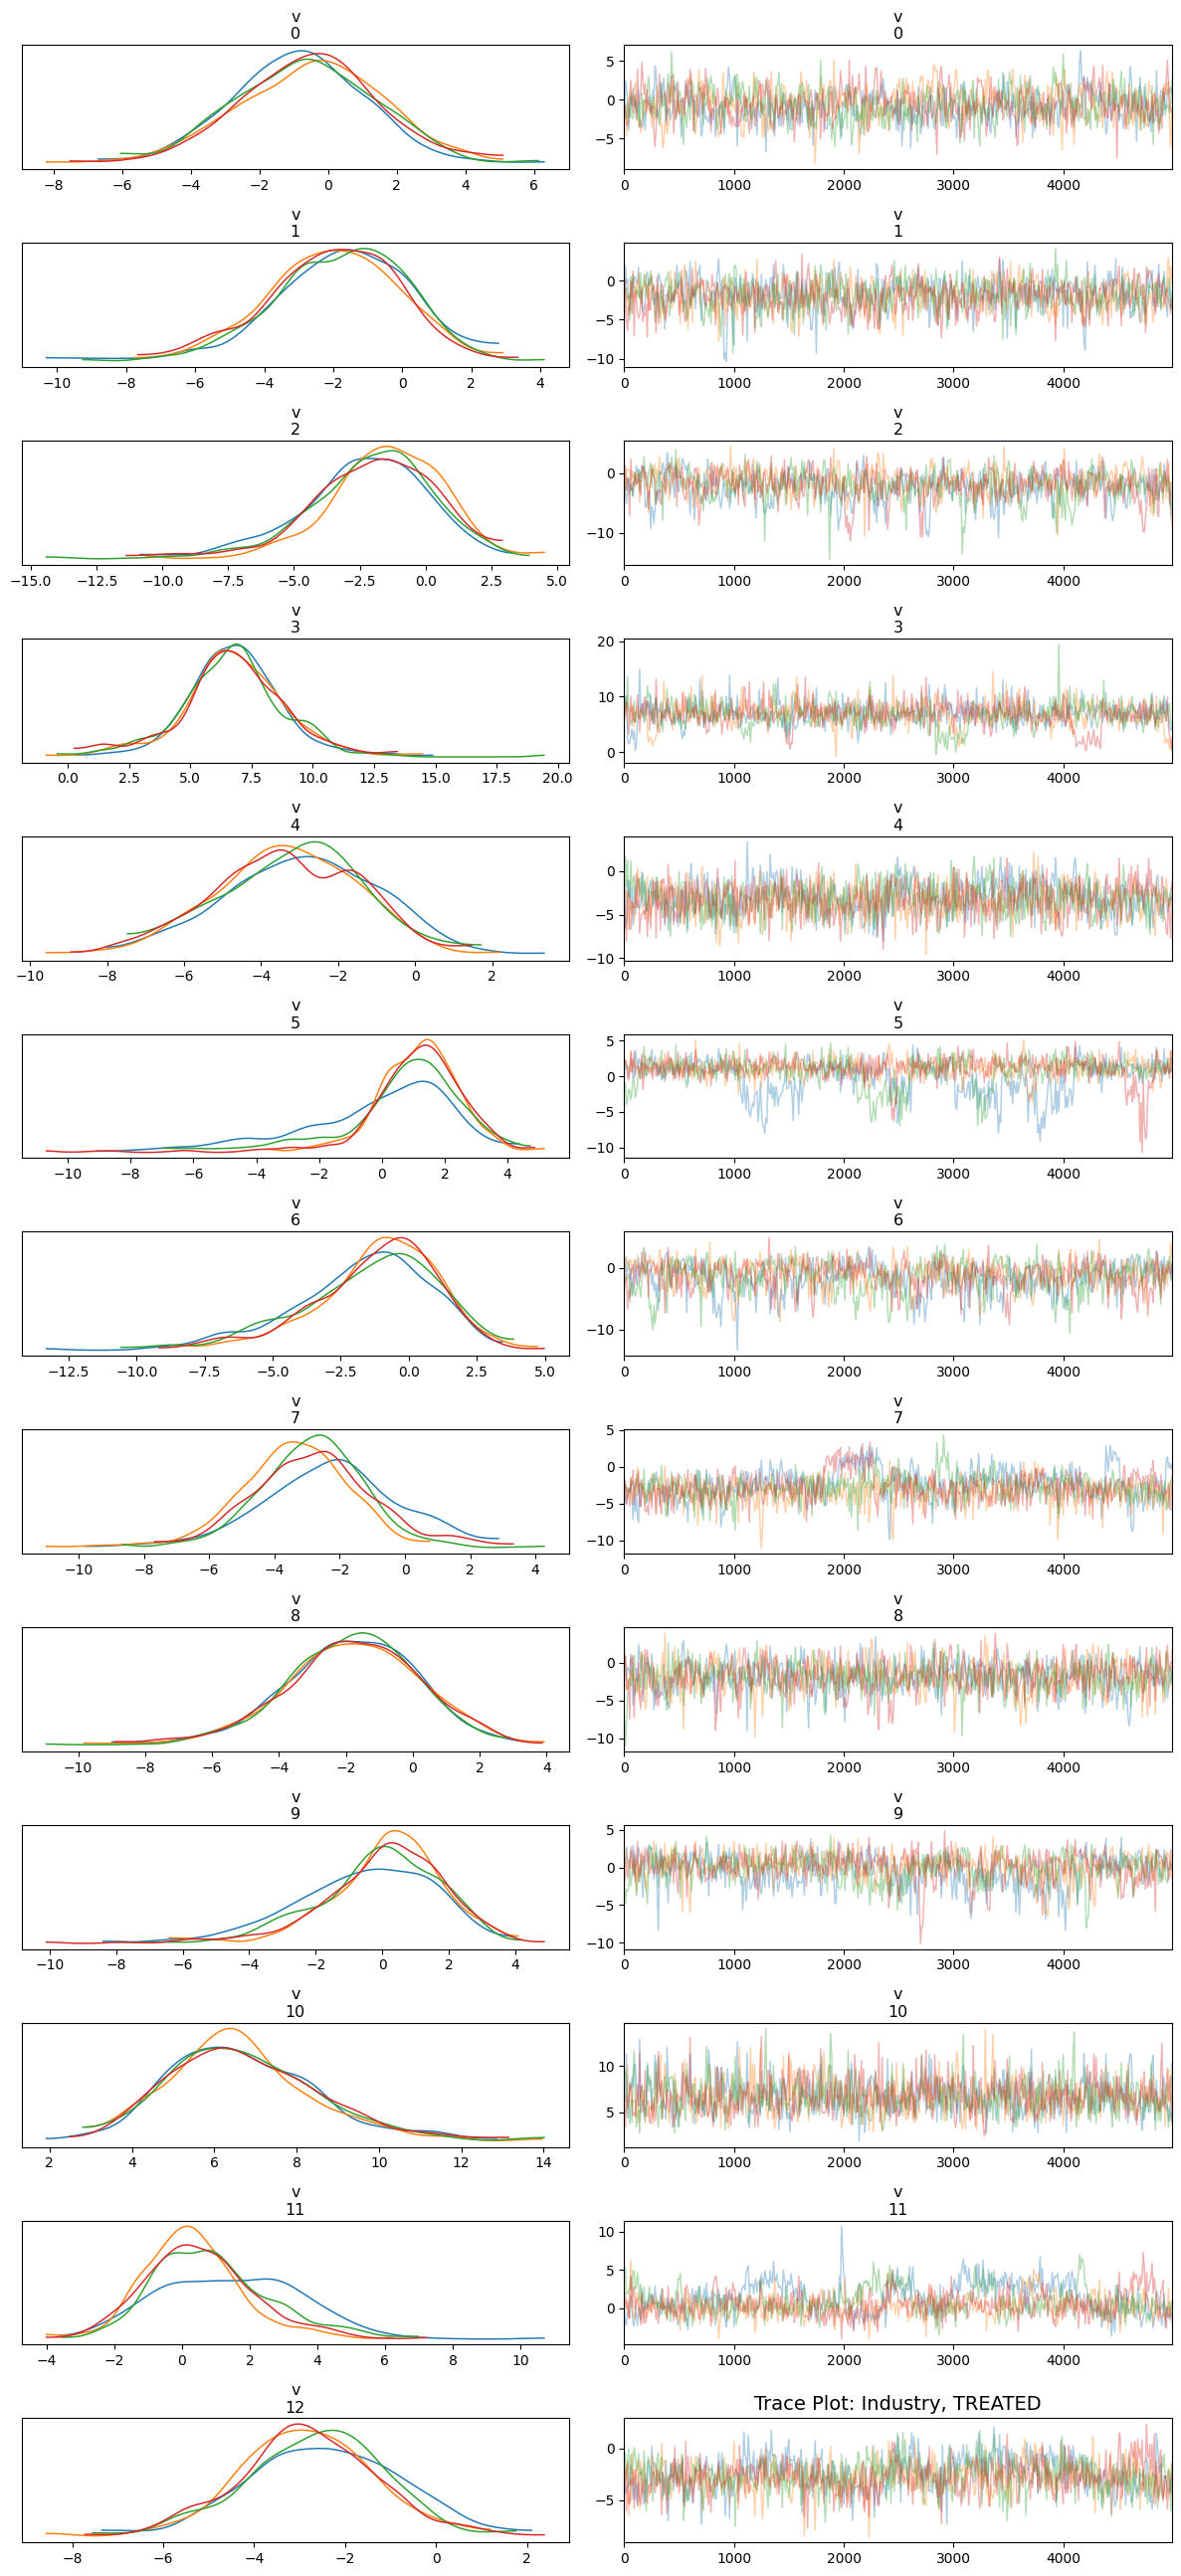

In [48]:
for i in range(len(VAR)):
    az.plot_trace(
        data=trace_thinned, 
        var_names=VAR[i], 
        compact=False,
    )
    plt.title(
        label=f"Trace Plot: Industry, {VAR_RENAME[i]}", 
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()

### AutoCorrelation

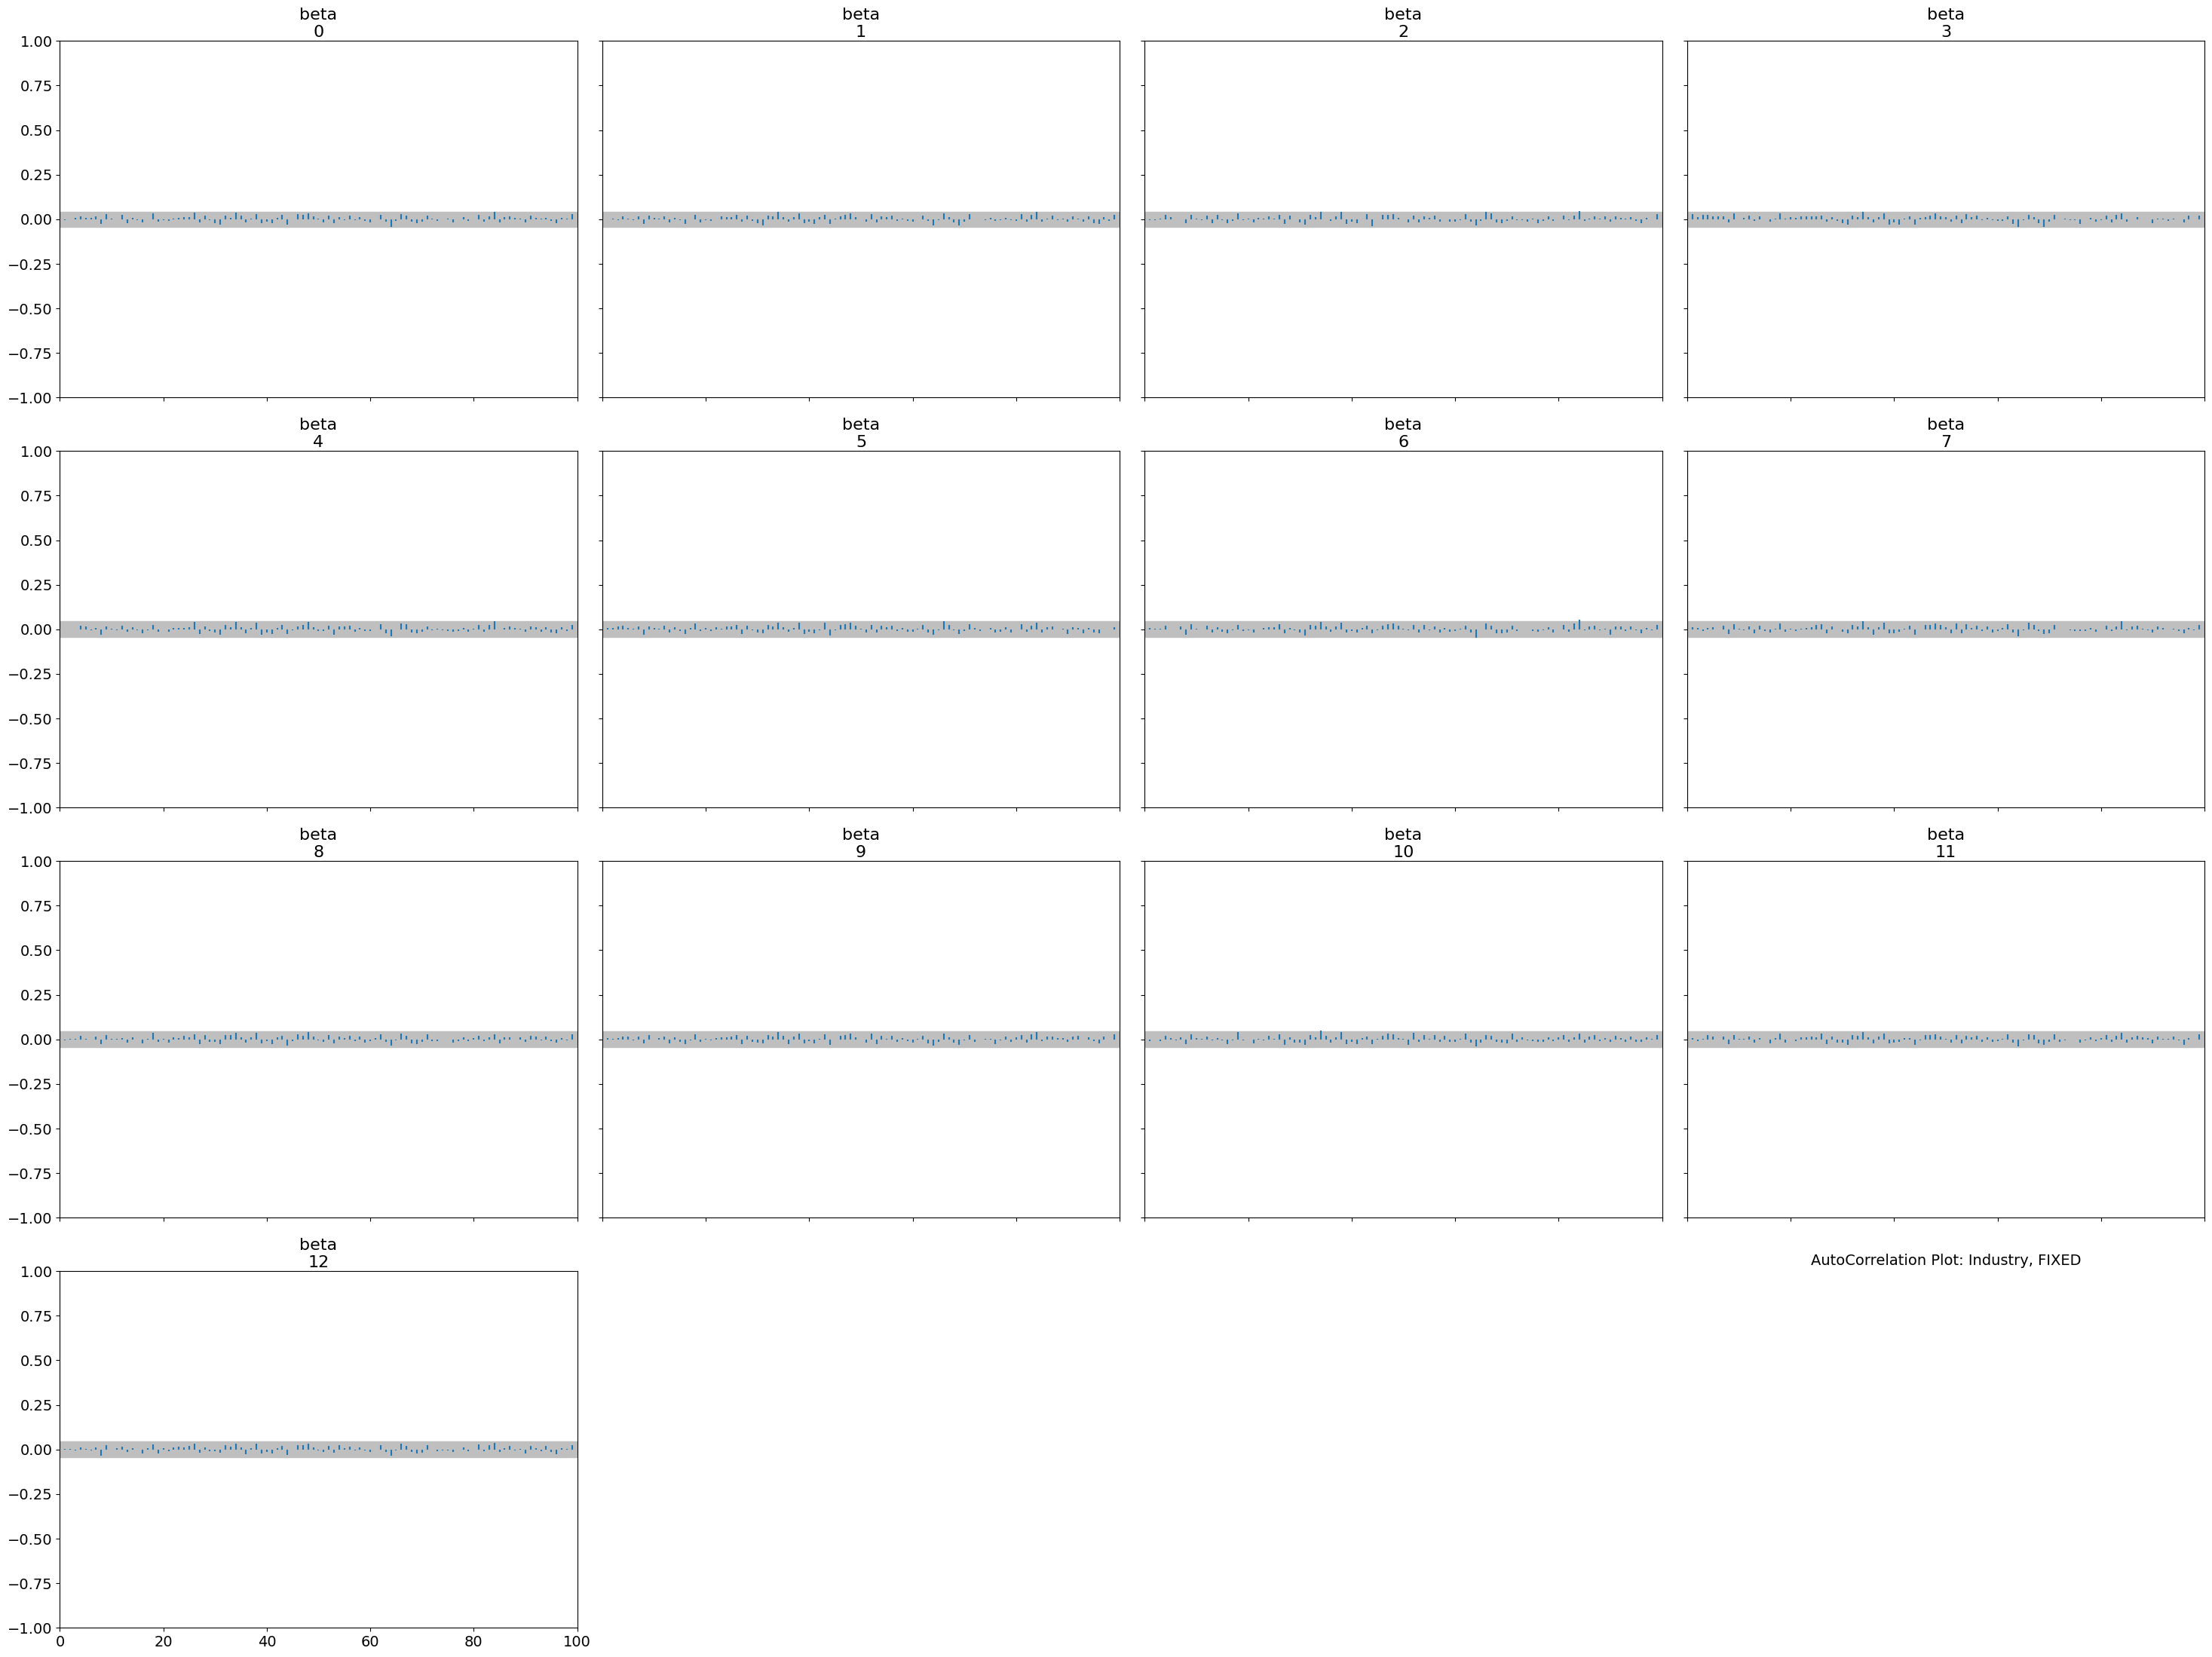

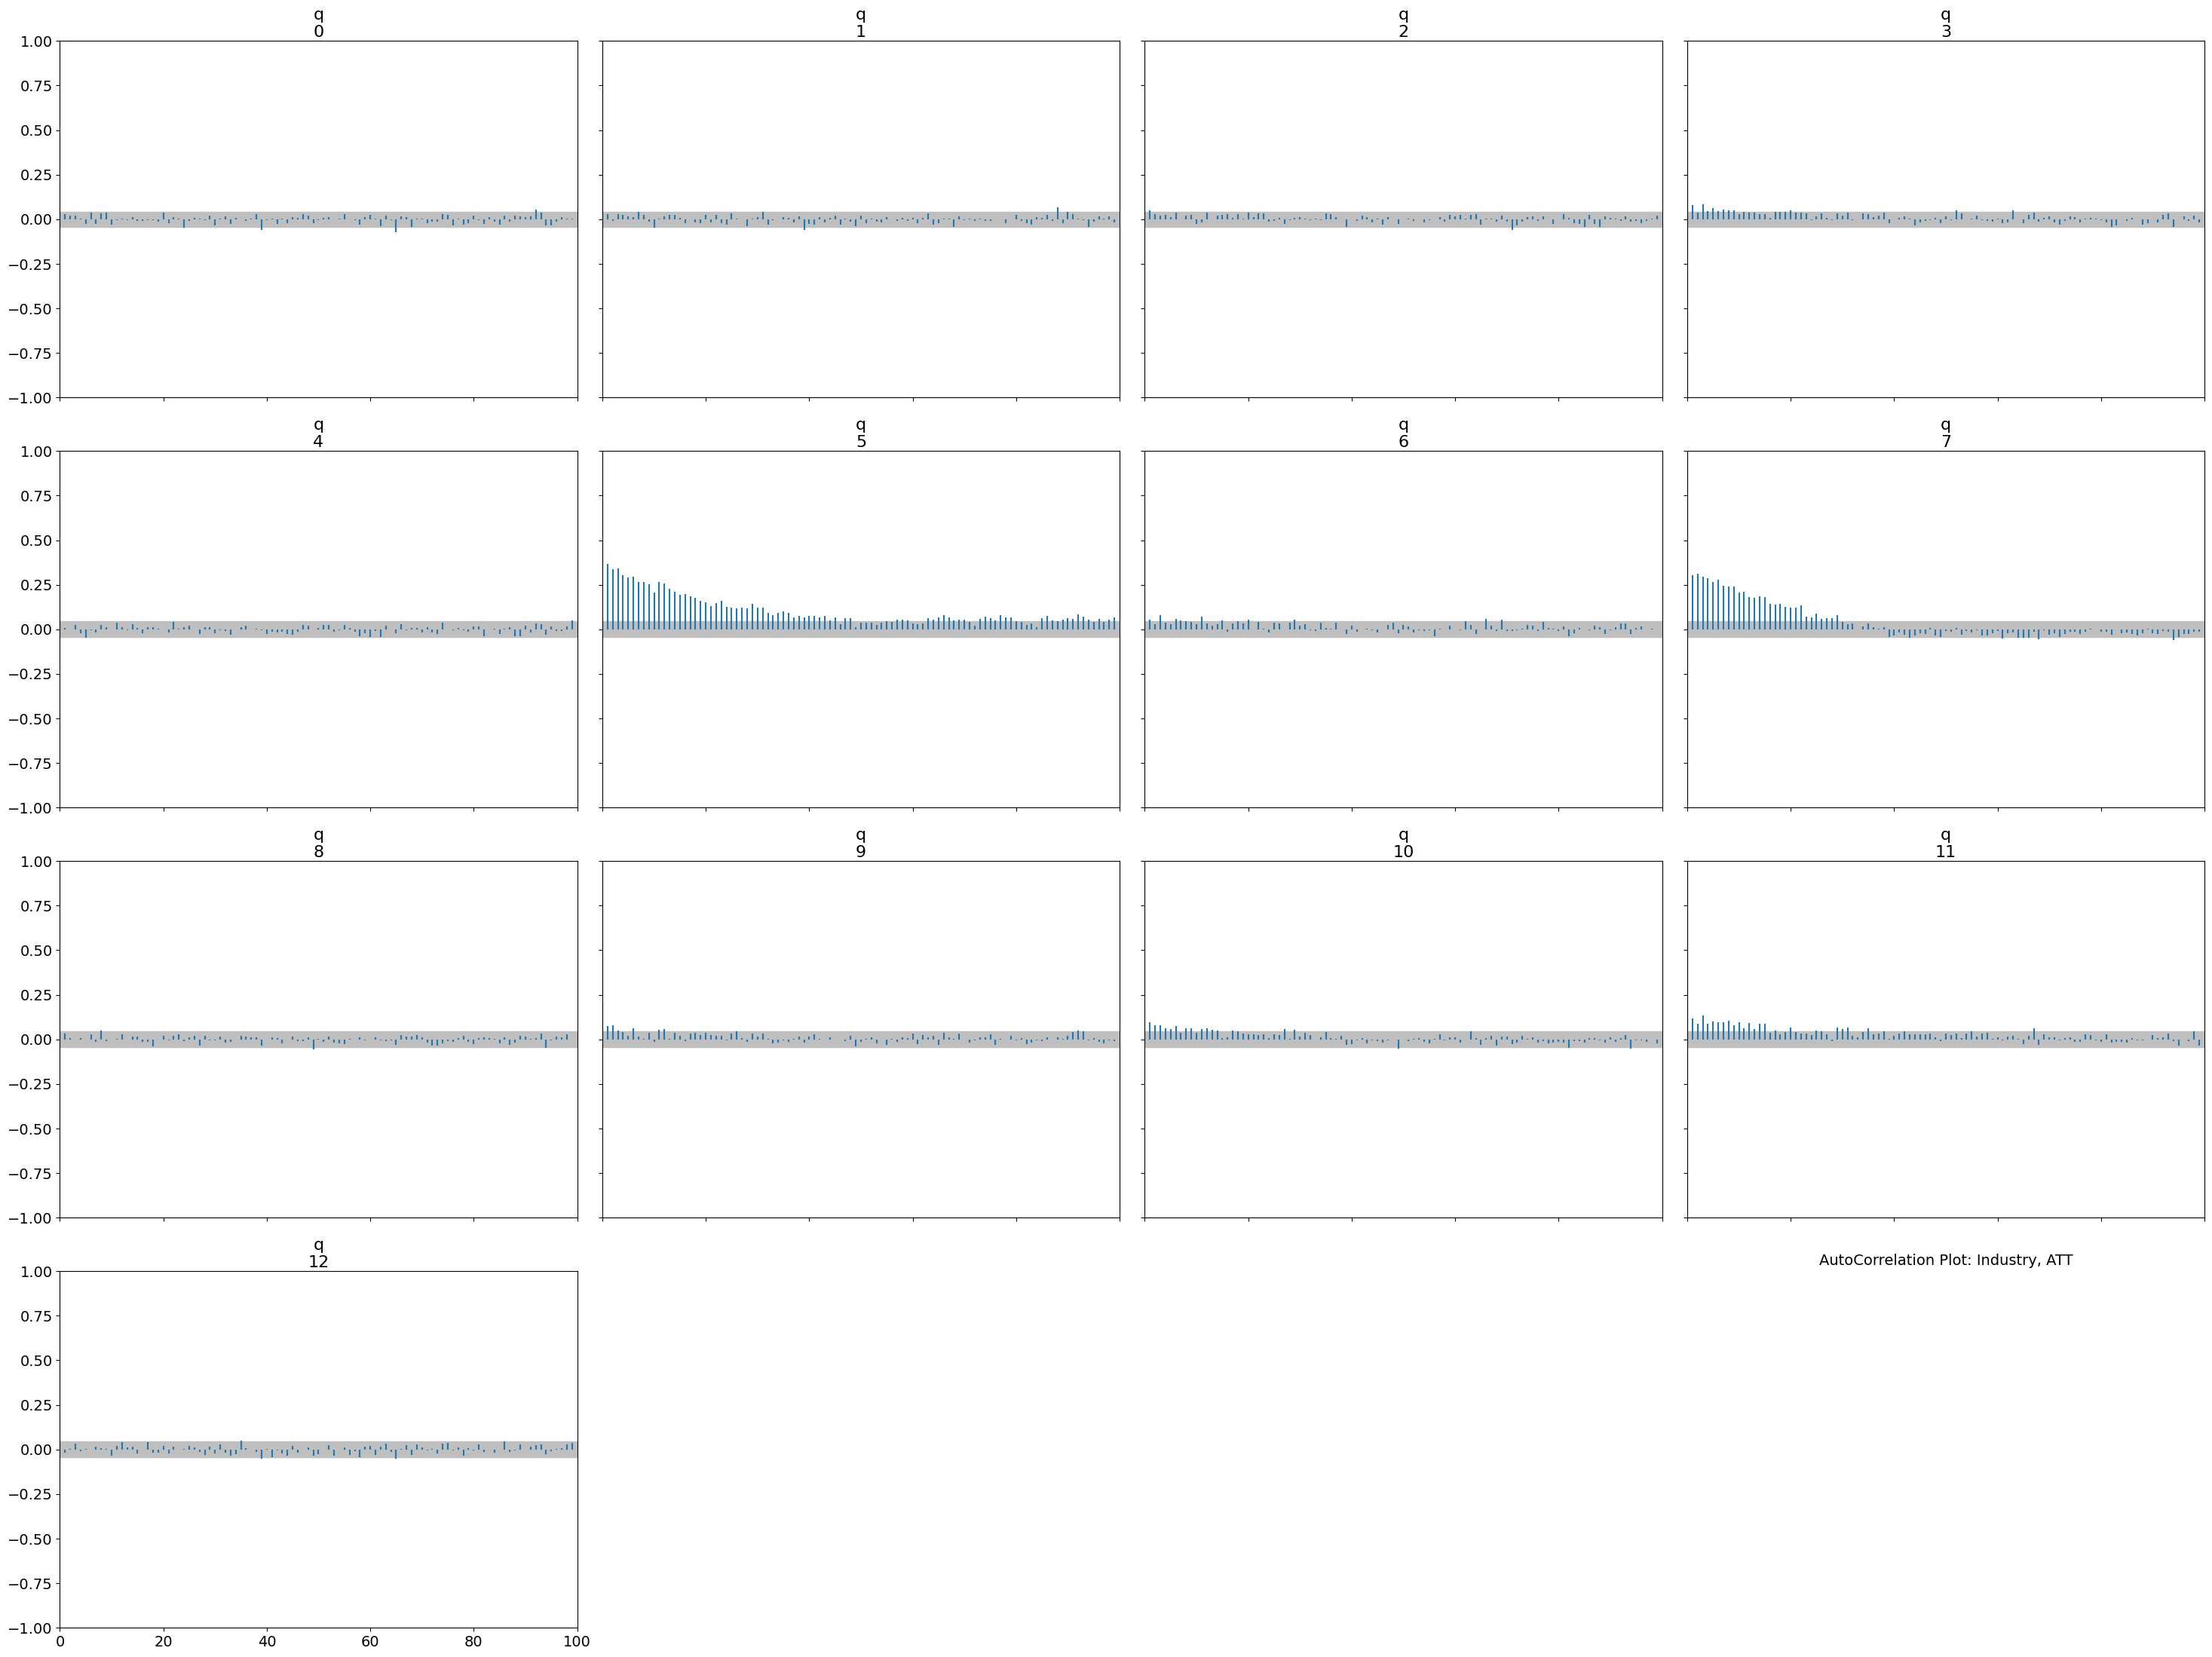

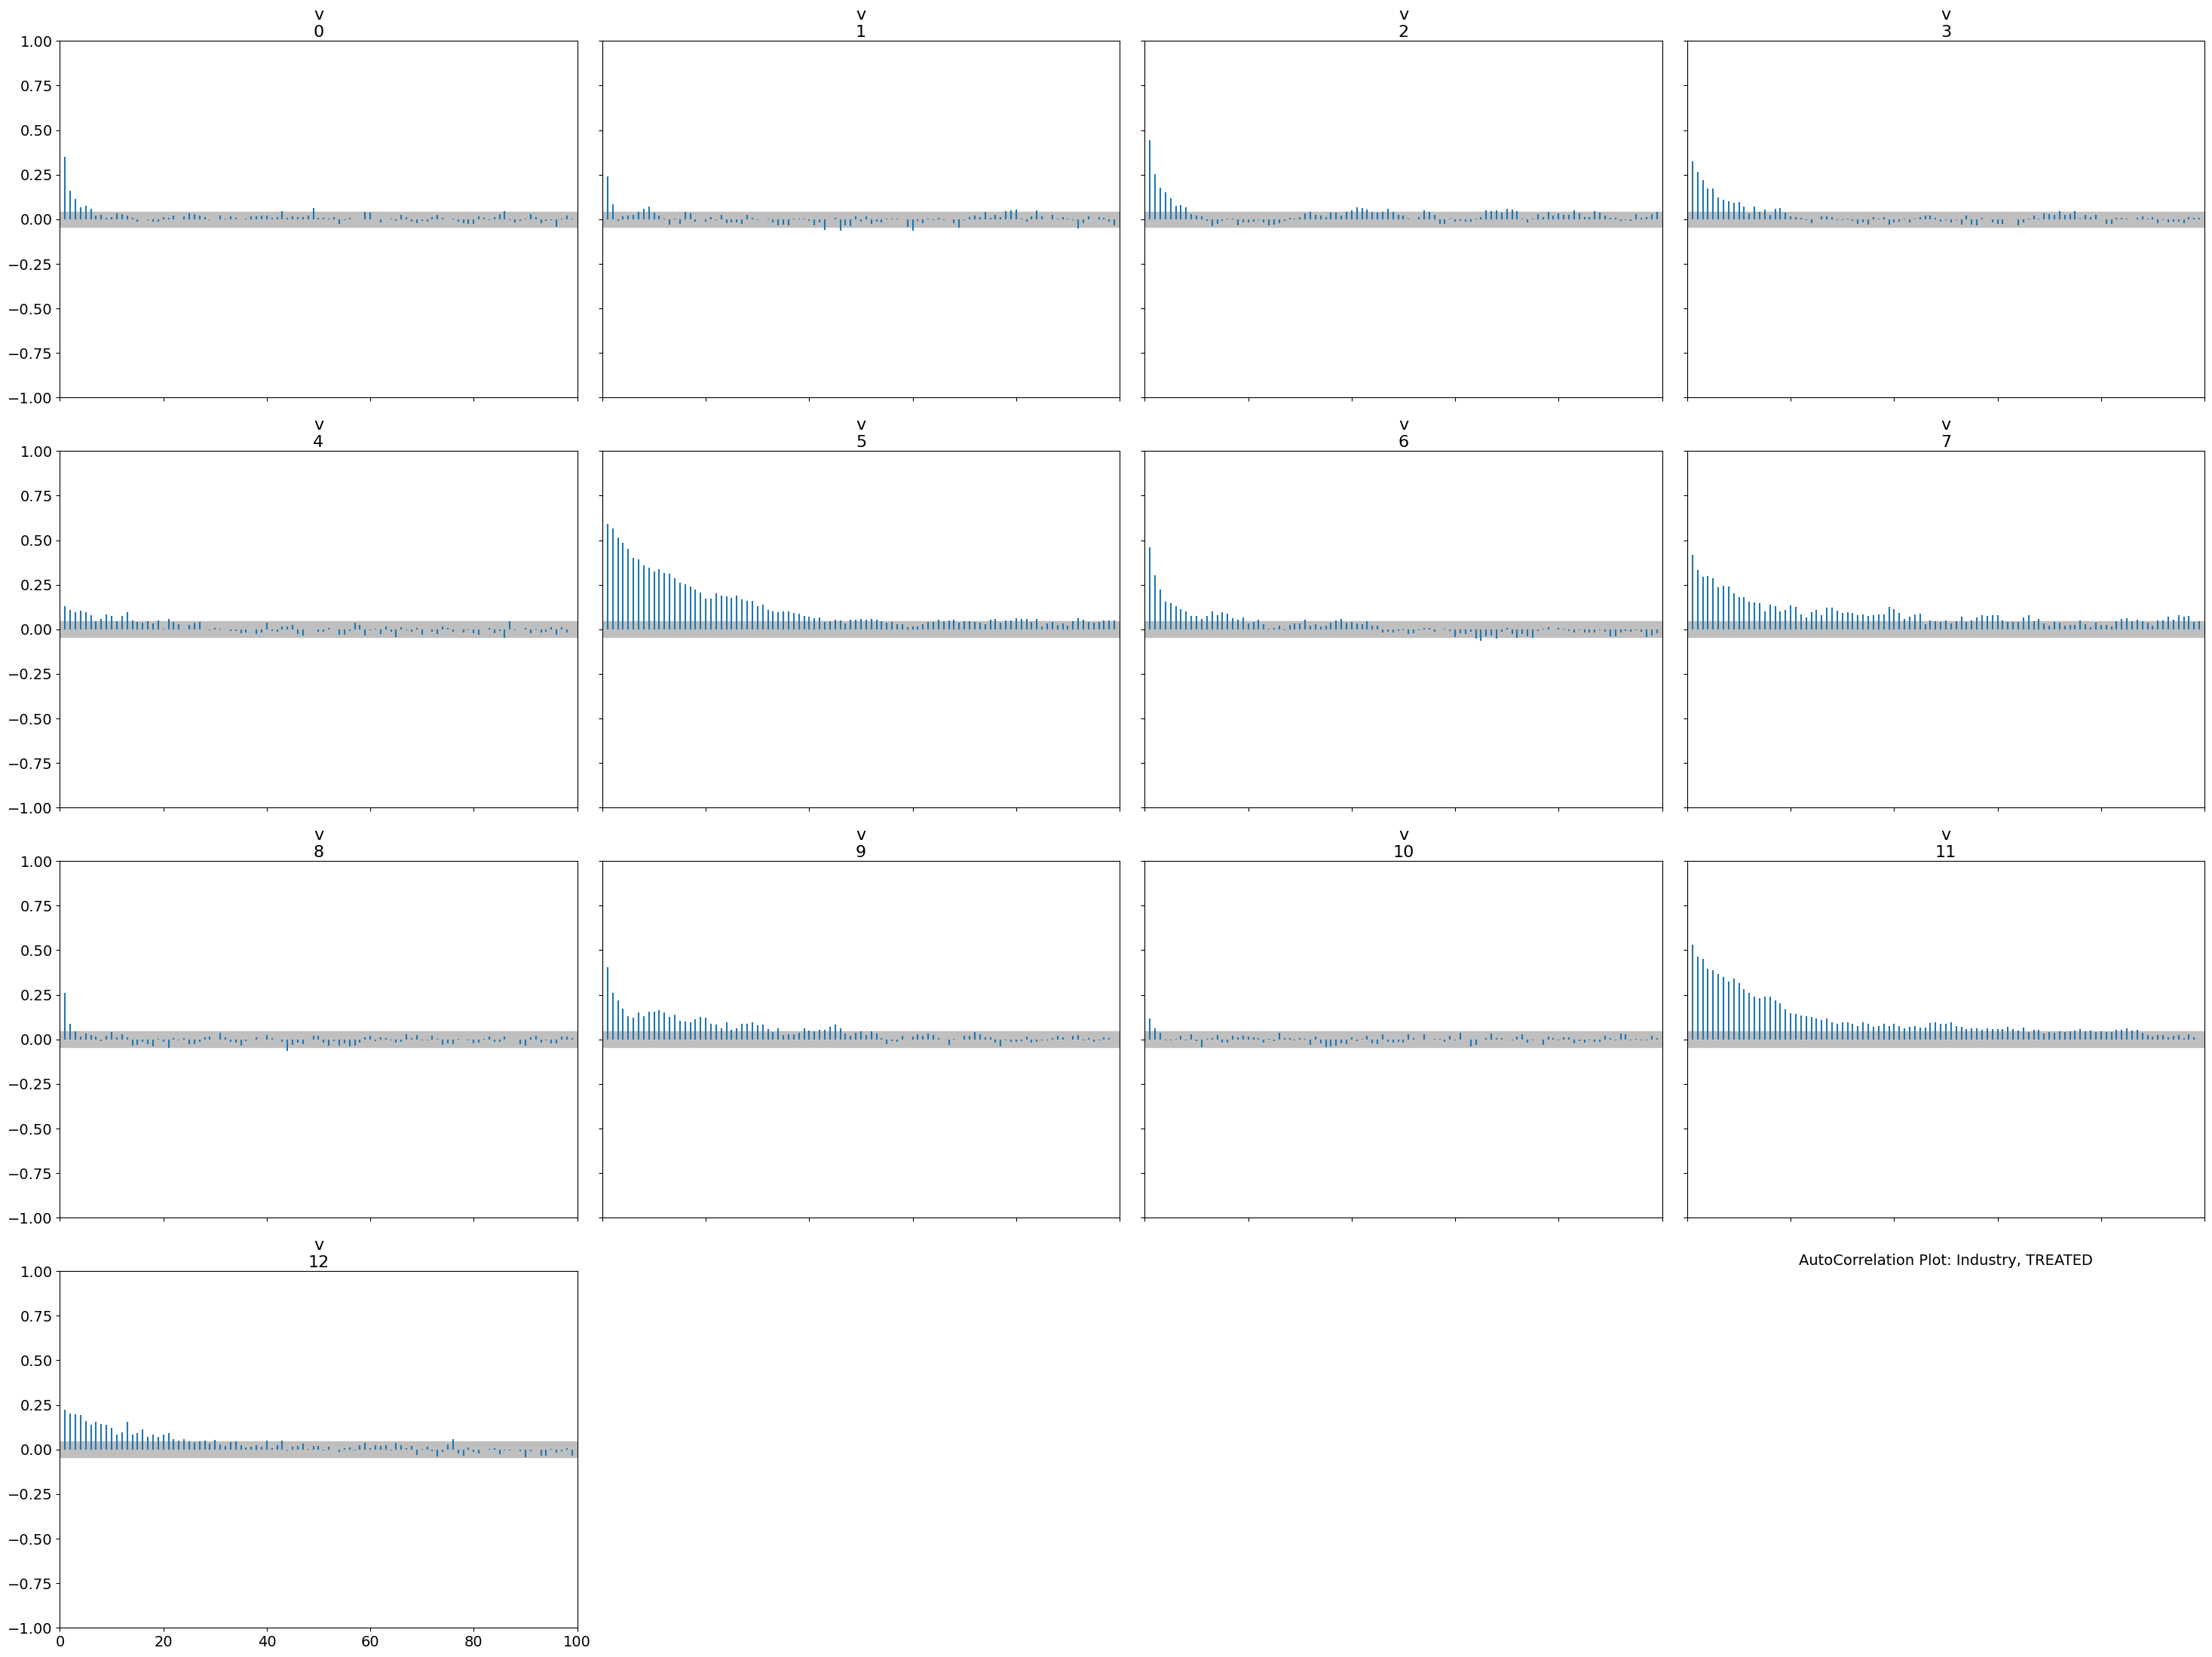

In [49]:
for i in range(len(VAR)):
    az.plot_autocorr(
        data=trace_thinned, 
        var_names=VAR[i],
        combined=True,
    )
    plt.title(
        label=f"AutoCorrelation Plot: Industry, {VAR_RENAME[i]}", 
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()